# Deep Learning
## Summative assessment
### Coursework 3

#### Instructions

This coursework is released on **Wednesday 20th March 9.00** and is due by **Wednesday 24th April 23.59**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 100 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a generative deep learning model for a spoken audio dataset.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file), PDF report and model submission.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook, separate PDF/HTML file(s), model(s) and any other relevant files to Coursera by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [1]:
#! pip install pydub==0.25.1 -q

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import os
from IPython.display import Audio, display

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Layer, Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Mean
from tensorflow.keras.datasets import mnist
import tensorflow_probability as tfp
tfpd = tfp.distributions
tfpl = tfp.layers
tfpb = tfp.bijectors

#### The Free Spoken Digit Dataset (FSDD)

This assessment makes use of the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset). This dataset consists of recordings of spoken digits by a number of different speakers, all recorded at a sample rate of 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends.

For this assessment, we will use the version of the dataset made available through TensorFlow Datasets ([https://www.tensorflow.org/datasets/catalog/spoken_digit](https://www.tensorflow.org/datasets/catalog/spoken_digit)).

The dataset consists 2,500 recordings from 5 different speakers. Using the TensorFlow Datasets API, this dataset can be downloaded and stored directly in a Dataset object using the code below.

In [3]:
ds = tfds.load(
    'spoken_digit',
    split='train',
    data_dir=os.path.join("data", "spoken_digit"),
    shuffle_files=False
)

2024-04-23 06:26:41.021456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 06:26:41.136361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 06:26:41.137353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
ds.element_spec

{'audio': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'audio/filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

#### VQ-VAE

The VQ-VAE was first developed in the following paper:

* van den Oord, A., Vinyals, O. & Kavukcuoglu, K. (2017), "Neural discrete representation learning", _Proceedings of the 31st International Conference on Neural Information Processing Systems_, 6309-6318.

In this assessment you will develop and train a vector-quantised variational autoencoder (VQ-VAE) model. This is a variant of the VAE algorithm that makes use of a discrete latent space. In particular, the VQ-VAE defines a _codebook_ $\mathbf{e} \in \mathbb{R}^{K \times D}$ for the latent embedding space, consisting of $K$ latent embedding vectors $e_i$ ($i=1,\ldots,K$), each of dimension $D$. The algorithm involves training encoder and decoder networks as usual. However, for a given input $x$, the encoder output $E(x) \in \mathbb{R}^D$ is quantised to the nearest latent embedding vector:

$$VQ(E(x)) = e_k,\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j||_2,$$

where the $||\cdot||_2$ norm above is the Euclidean norm in $\mathbb{R}^D$. This quantized latent vector is then passed through the decoder to output the likelihood $p_\theta(x \mid z)$ as usual.

The quantisation stage of the VQ-VAE means that it is not possible to compute gradients with respect to the encoder variables. The solution to this problem in the VQ-VAE is to use the _straight through estimator_, in which the gradients computed with respect to the quantised embeddings are simply passed unaltered to the encoder. This process means that the codebook embeddings $e_i$ do not receive any gradient updates (for details, refer to the implementation referenced in question 3, which makes this process explicit). The VQ-VAE objective therefore adds two additional terms to learn the codebook embeddings:

$$
L = \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z) ] + ||\textrm{sg}[E(x)] - VQ(E(x))||^2_2 + \beta || E(x) - \textrm{sg}[VQ(E(x))]||_2^2
$$

In the above, $\textrm{sg}$ is the _stop gradient_ operator that is defined as identity in the forward pass but has zero partial derivates (see [`tf.stop_gradient`](https://www.tensorflow.org/api_docs/python/tf/stop_gradient)). This means that when evaluating the loss function above, the stop gradient operator can be ignored, but when computing derivatives of the loss with respect to the model parameters, the partial derivatives of $\textrm{sg}[E(x)]$ and $\textrm{sg}[VQ(E(x))]$ with respect to the model parameters will be zero. The constant $\beta$ is usually taken set to $\beta=0.25$ by default, as in the original paper.

The first term in the objective $L$ above is the reconstruction loss, the second term is the _codebook loss_, and the third term is the _commitment loss_. The Kullback-Leibler divergence term in the ELBO is constant and so is ignored for training.

In this assessment, you will design, implement, train and evaluate a VQ-VAE for the spoken digit dataset, and use it to learn a generative model of the spoken audio.

### Question 1 (Total 15 marks)

The loaded Dataset returns a dictionary with keys `"audio"`, `"audio/filename"` and `"label"`. For this assessment you will only need the `"audio"` entry, and the other entries can be discarded.

In this question, you should carry out a basic exploration and analysis of the dataset; computing, displaying and visualising any properties you deem to be relevant. You can also use comments and/or markdown as appropriate.

All of the Dataset preparation/preprocessing for question 2a) should be done in this question, so that it is ready for training the VQ-VAE.

_Hint: an audio file can be played within a jupyter notebook using the `Audio` class from the `IPython.display` module (imported above). See [here](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html) for usage._

**(15 marks)**

#### Exploratory Data Analysis

In [5]:
# Check cardinality of the dataset
print(tf.data.experimental.cardinality(ds).numpy())

2500


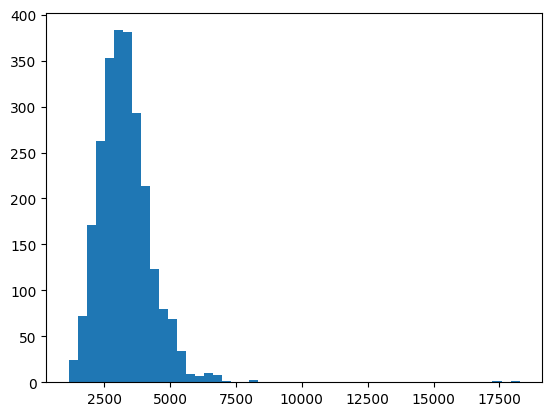

In [6]:
# Get the maximum length of the audio data
lengths = []
for elem in ds.as_numpy_iterator():
    lengths.append(elem['audio'].shape[0])

# plot lenghts
plt.hist(lengths,bins=50)
plt.show()

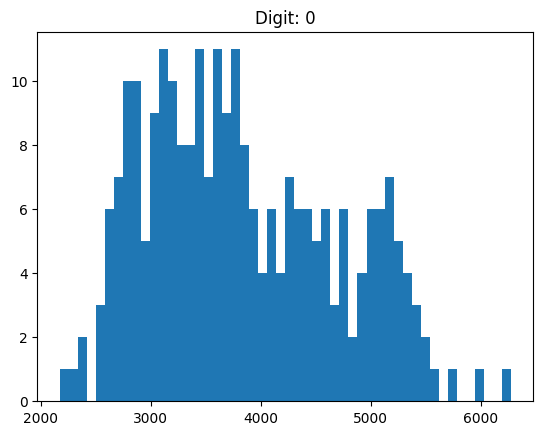

Median + 1.5*IQR = 2443.2412500000005


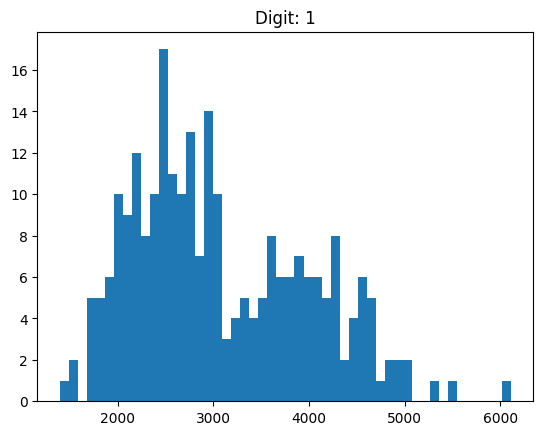

Median + 1.5*IQR = 1658.8174999999997


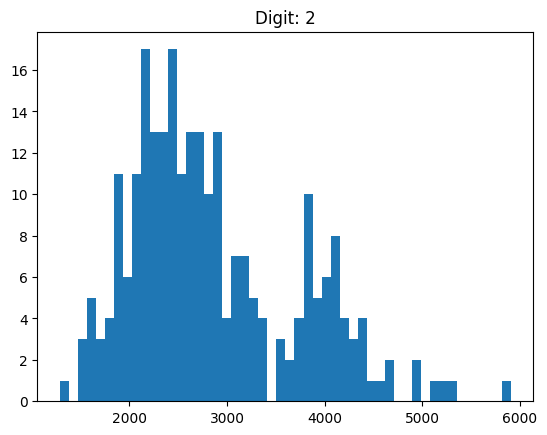

Median + 1.5*IQR = 1608.72125


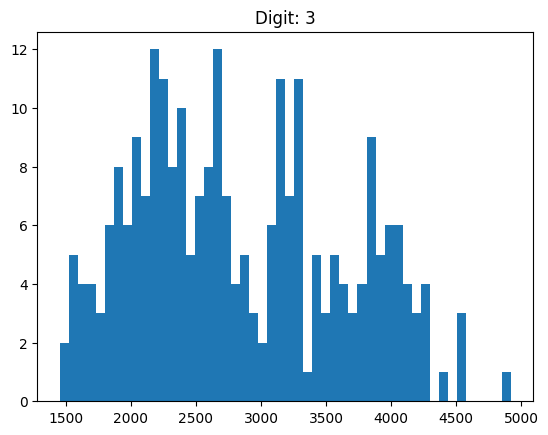

Median + 1.5*IQR = 1573.735


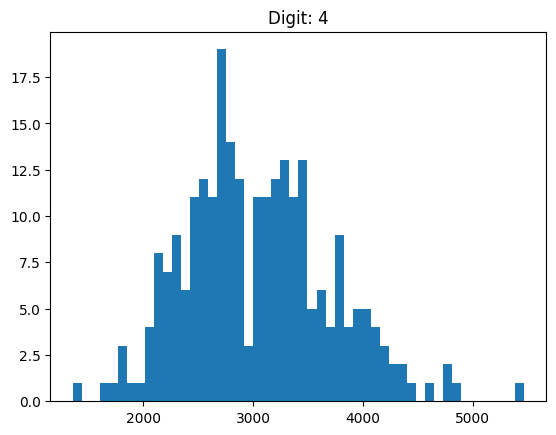

Median + 1.5*IQR = 1899.4625


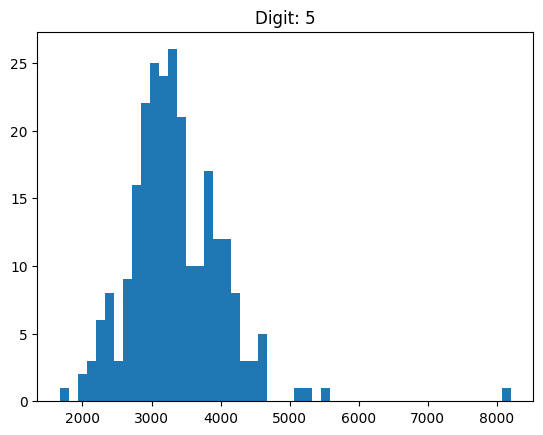

Median + 1.5*IQR = 2254.145


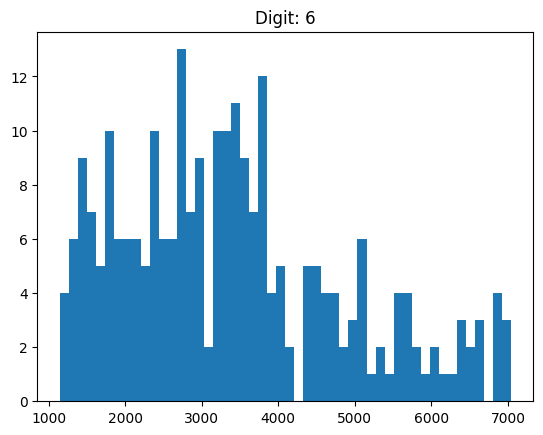

Median + 1.5*IQR = 1307.28375


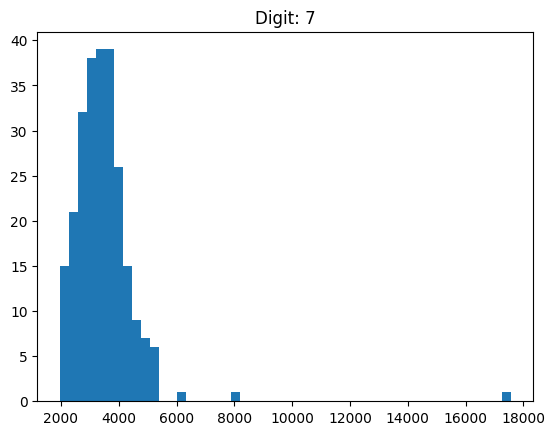

Median + 1.5*IQR = 2016.28625


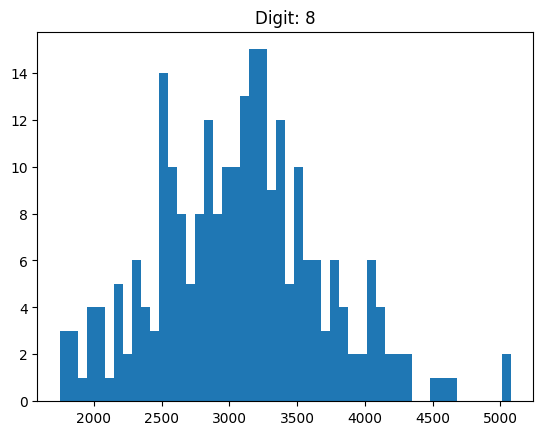

Median + 1.5*IQR = 1836.71


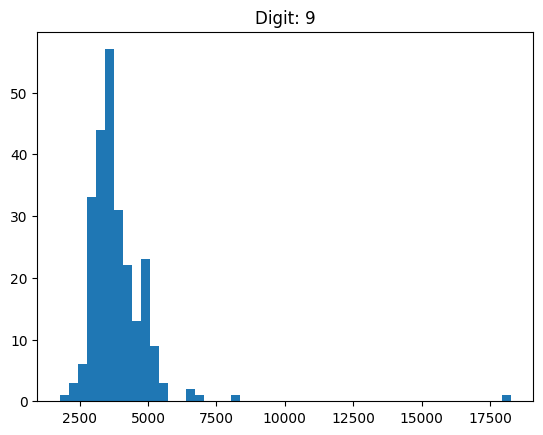

Median + 1.5*IQR = 2513.5375


In [7]:
# Show for each digit
for d in range(10):
    lengths=[]
    for elem in ds.filter(lambda x:x['label']==d).as_numpy_iterator():
        lengths.append(elem['audio'].shape[0])
    plt.hist(lengths,bins=50)
    plt.title('Digit: '+str(d))
    plt.show()

    lengths = np.array(lengths)
    q75,q50,q25 = np.percentile(lengths,[0.75,0.5,0.25])
    iqr = q75-q25
    iqr_threshold = q50 + 1.5*iqr
    print('Median + 1.5*IQR =',iqr_threshold)

To minimise the need for excessive padding, I will filter out entries with audio longer than 7000 values. From the above, this will remove some of the outliers for some of the digits

In [8]:
ds_filtered = ds.filter(lambda x: tf.shape(x['audio'])[0]<=7000)

In [9]:
# get data max
data_max = 0
for elem in ds_filtered.as_numpy_iterator():
    data_max = max(elem['audio'].max(),data_max)
print(data_max)

32767


In [10]:
# Load the first 6 elements into a list and print the shapes of the audio data
sample_list =[]
for element in ds_filtered.take(6):
    print(element['audio'])
    sample_list.append(element)

tf.Tensor([   0    0 -256 ... -512 -256 -512], shape=(1525,), dtype=int64)
tf.Tensor([   0    0    0 ... -256    0    0], shape=(2929,), dtype=int64)
tf.Tensor([-10  -6 -25 ... -26  -8 -14], shape=(6457,), dtype=int64)
tf.Tensor([ 0  2 -3 ... -3  0  2], shape=(3360,), dtype=int64)
tf.Tensor([-256    0 -256 ... -512    0    0], shape=(2746,), dtype=int64)
tf.Tensor([-6 20  7 ...  5 21 43], shape=(3306,), dtype=int64)


The above shows that the dimension of the data varies from input to input. This is a bit of an issue, as in tensorflow dimensions must be fixed at least throughout a batch (see [here](https://stackoverflow.com/questions/47479587/how-to-feed-input-with-changing-size-in-tensorflow)). The solution would be to fix the length of the input by finding the maximum length and using `np.pad`.

Another issue is the fact that the data is currently integers. For our purposes, we will need to convert this to floats. [SOURCE]

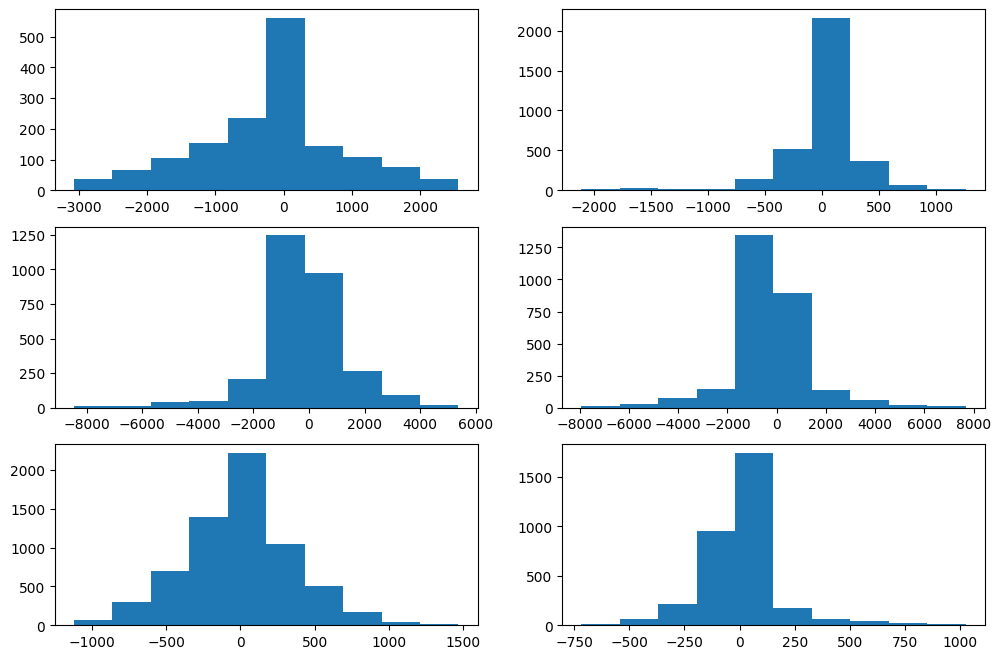

In [11]:
# Visualise the distribution of values using histograms
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(12,8))
for i in range(3):
    ax[i,0].hist(sample_list[i]['audio'].numpy())
    ax[i,1].hist(sample_list[i+3]['audio'].numpy())

As expected, the soundwave data is has a relatively symmetrical distribution, and is centered upon zero. My assumption is that padding the audio data with zeros to solve for the issue mention above will essentially be equivalent to adding silence to the audio clips.

In this next section if the EDA, I will explore compare the time and spectral representations of the audio clips to see whether there are any similarities withing the digit groups

In [12]:
# Create a nested list of 5 audio samples per digit
samples = []
for i in range(10):
    digit_sample = list(ds_filtered.filter(lambda x: x['label']==i).take(4))
    samples.append(digit_sample)

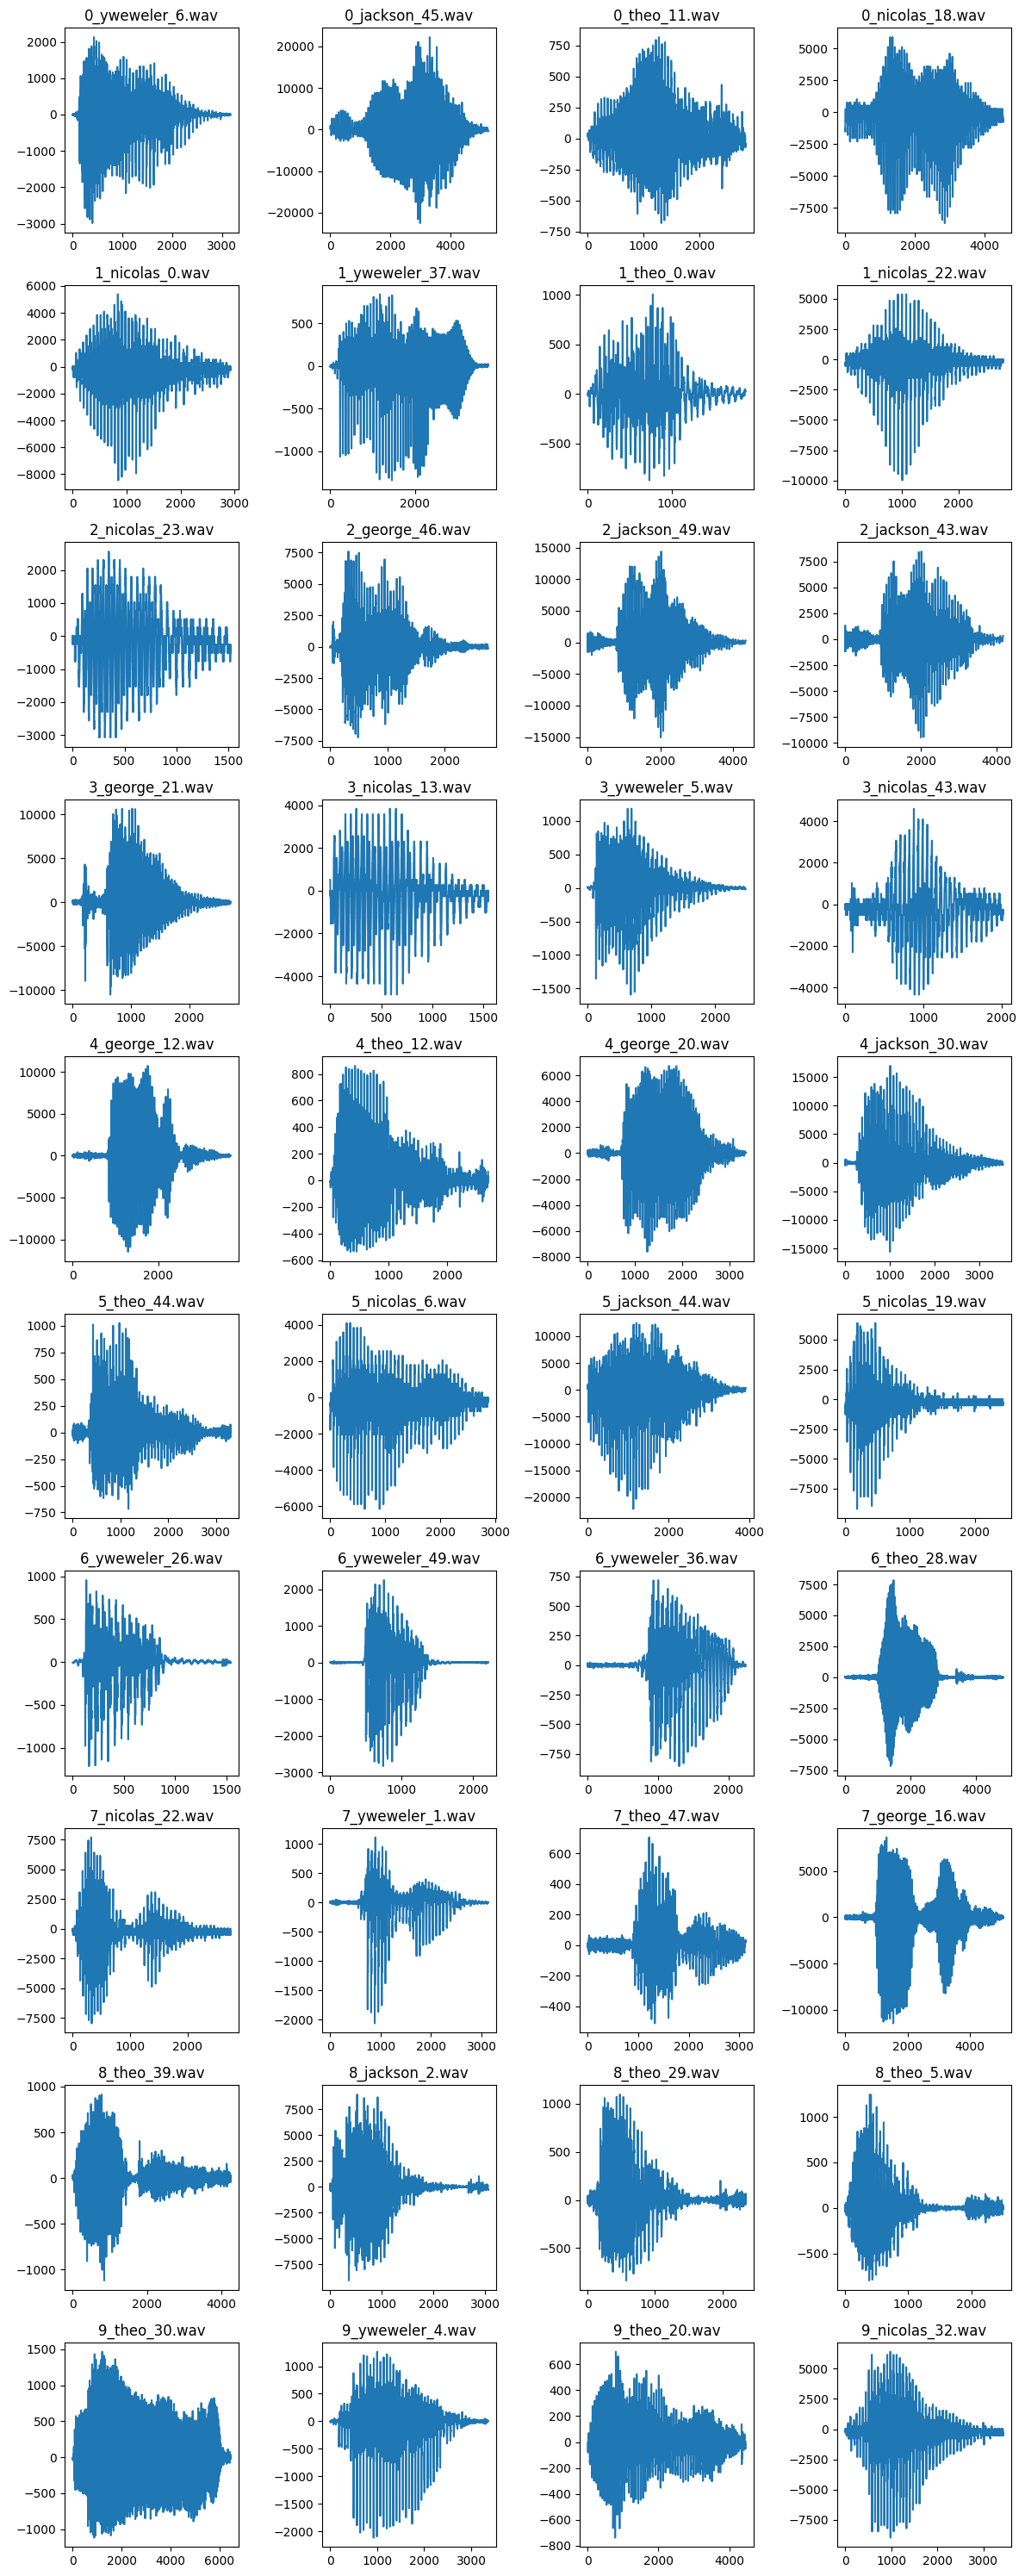

In [13]:
# Plot the amplitudes for each digit
fig, ax = plt.subplots(nrows=10,ncols=4,figsize=(12,30))

for digit in range(10):
    for col in range(4):
        title = samples[digit][col]['audio/filename'].numpy().decode('utf-8')
        data = samples[digit][col]['audio'].numpy()
        ax[digit][col].plot(data)
        ax[digit][col].set_title(title)
plt.tight_layout()
plt.show()

Distinctions across digits is more obvious for some digits than others. "seven" particularly seems to follow the same pattern. Next, I check the spectrogram

In [14]:
# Pad audio data
pad_len = 7000

for digit in range(10):
    for sample in range(4):
        samples[digit][sample]['audio'] = tf.concat([samples[digit][sample]['audio'],tf.zeros(pad_len-samples[digit][sample]['audio'].shape[0],tf.int64)],0)

(48, 129)


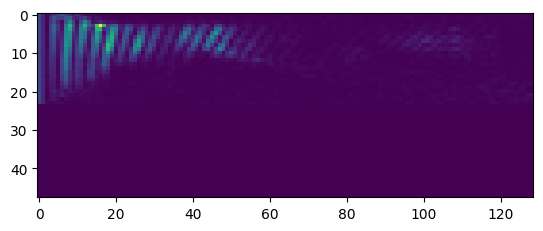

In [15]:
# Take one audio waveform and experiment to find the best frame length and step
frame_length = 255
frame_step =141

waveform = tf.cast(samples[9][3]['audio'],tf.float64)
stft = tf.signal.stft(waveform,frame_length,frame_step)
spectrogram = tf.abs(stft)
print(spectrogram.numpy().shape)
plt.imshow(spectrogram.numpy())
plt.show()

(48, 129)


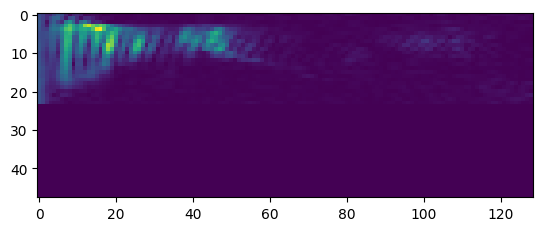

In [16]:
# Take one audio waveform and experiment to find the best frame length and step
frame_length = 155
frame_step = 143

waveform = tf.cast(samples[9][3]['audio'],tf.float64)
stft = tf.signal.stft(waveform,frame_length,frame_step)
spectrogram = tf.abs(stft)
print(spectrogram.numpy().shape)
plt.imshow(spectrogram.numpy())
plt.show()

(48, 129)


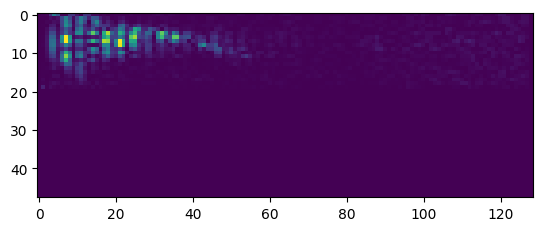

In [17]:
# Take one audio waveform and experiment to find the best frame length and step
frame_length = 255
frame_step = 141

waveform = tf.cast(samples[1][3]['audio'],tf.float64)
stft = tf.signal.stft(waveform,frame_length,frame_step)
spectrogram = tf.abs(tf.math.imag(stft))
print(spectrogram.numpy().shape)
plt.imshow(spectrogram.numpy())
plt.show()

(13, 33)


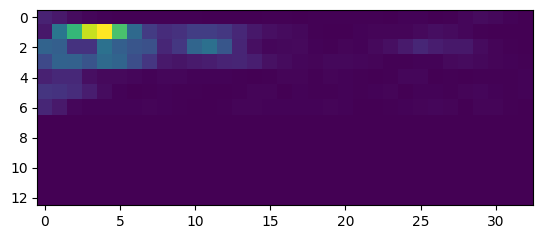

In [18]:
# Take one audio waveform and experiment to find the best frame length and step
frame_length = 55
frame_step = 555

waveform = tf.cast(samples[9][3]['audio'],tf.float64)
stft = tf.signal.stft(waveform,frame_length,frame_step)
spectrogram = tf.abs(stft)
print(spectrogram.numpy().shape)
plt.imshow(spectrogram.numpy())
plt.show()

(125, 123)


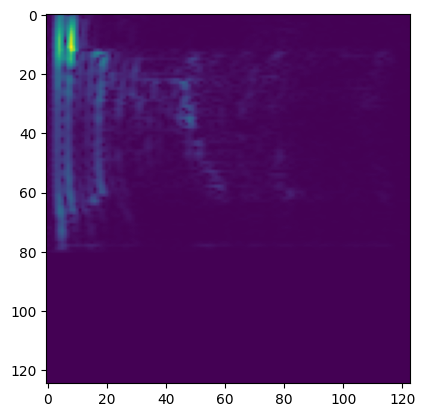

In [19]:
# Take one audio waveform and experiment to find the best frame length and step
frame_length = 55
frame_step = 146

waveform = tf.cast(samples[9][2]['audio'],tf.float64)
stft = tf.signal.stft(waveform,
                      155,
                      55,
                      fft_length=244
                     )
spectrogram = tf.abs(stft)
print(spectrogram.numpy().shape)
plt.imshow(spectrogram.numpy())
plt.show()

Based on the above, setting `frame_length`=255, `frame_step`=55 and `fft_length`=244. Below I plot the magnitude and the phase for one of each digit

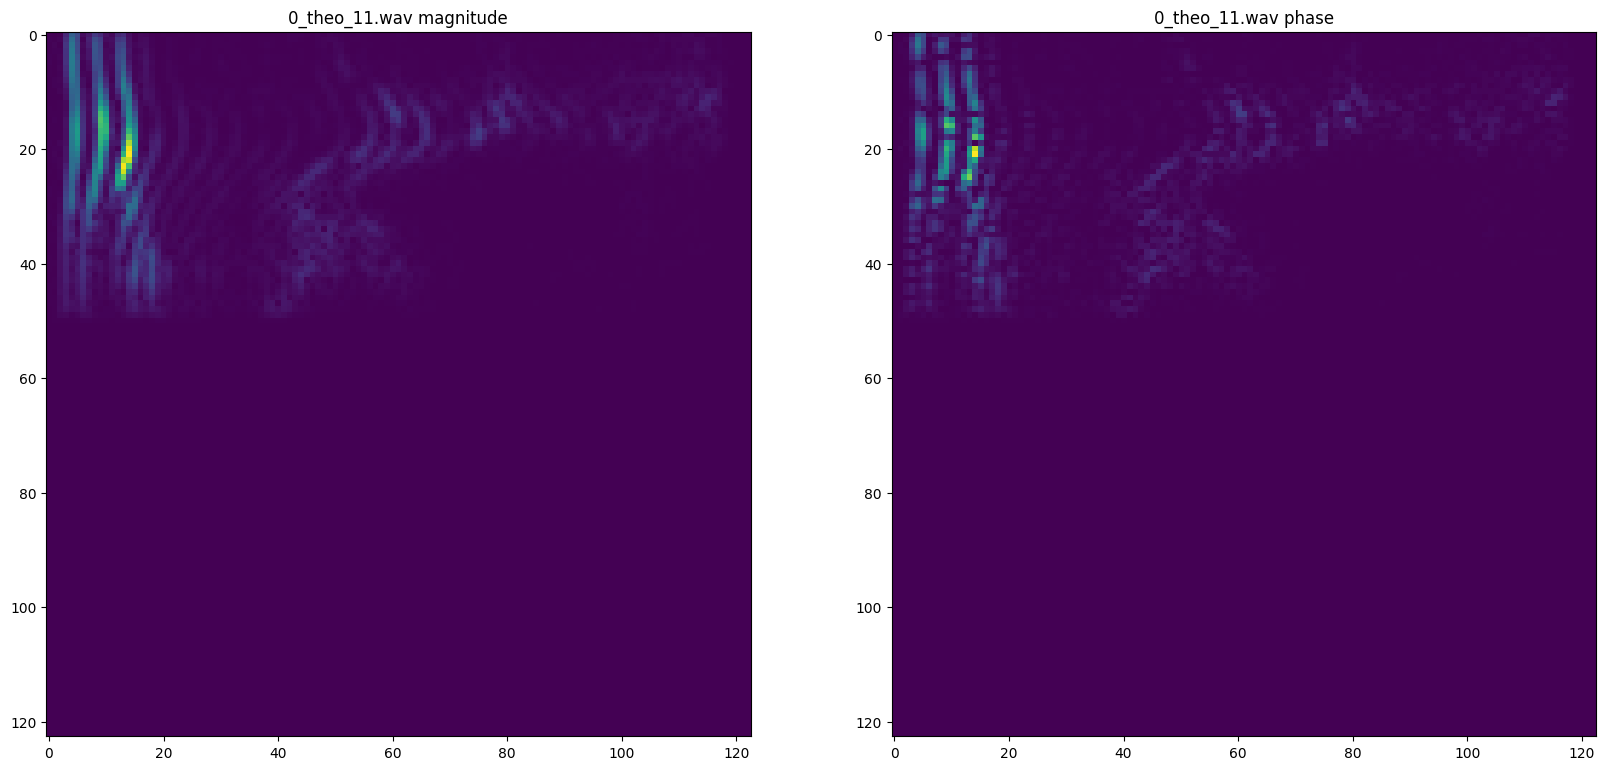

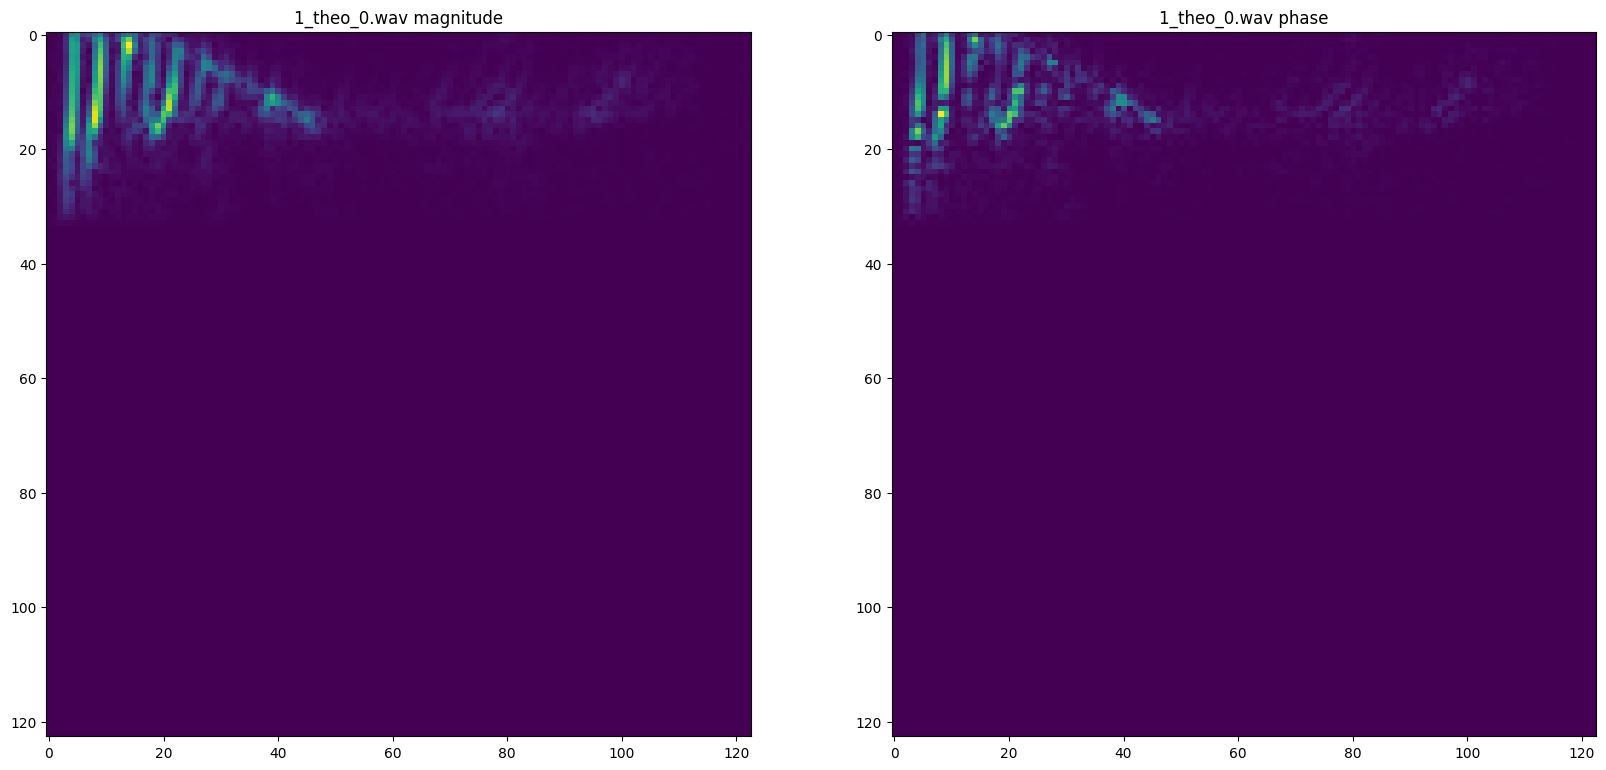

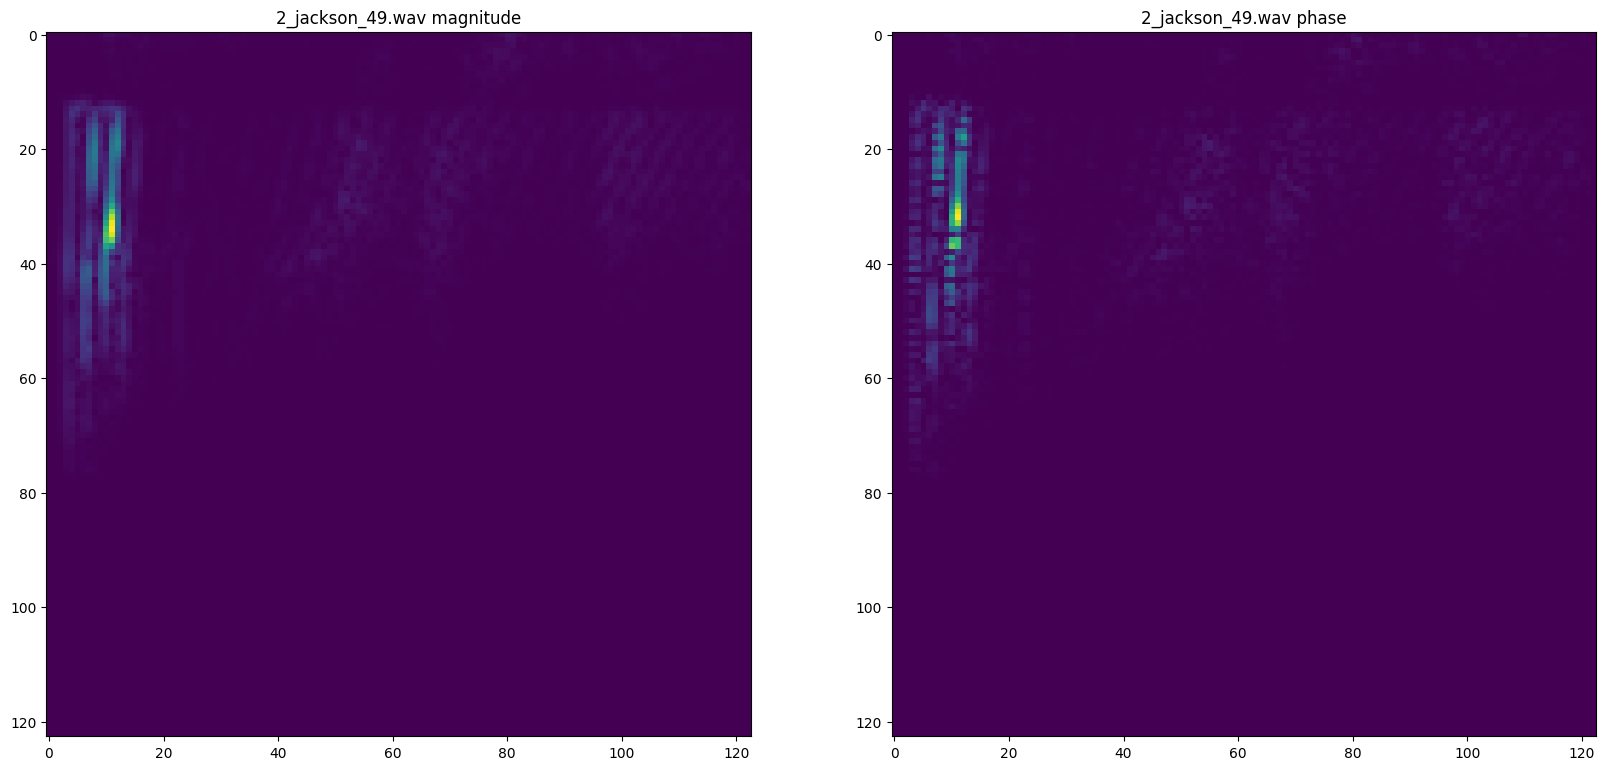

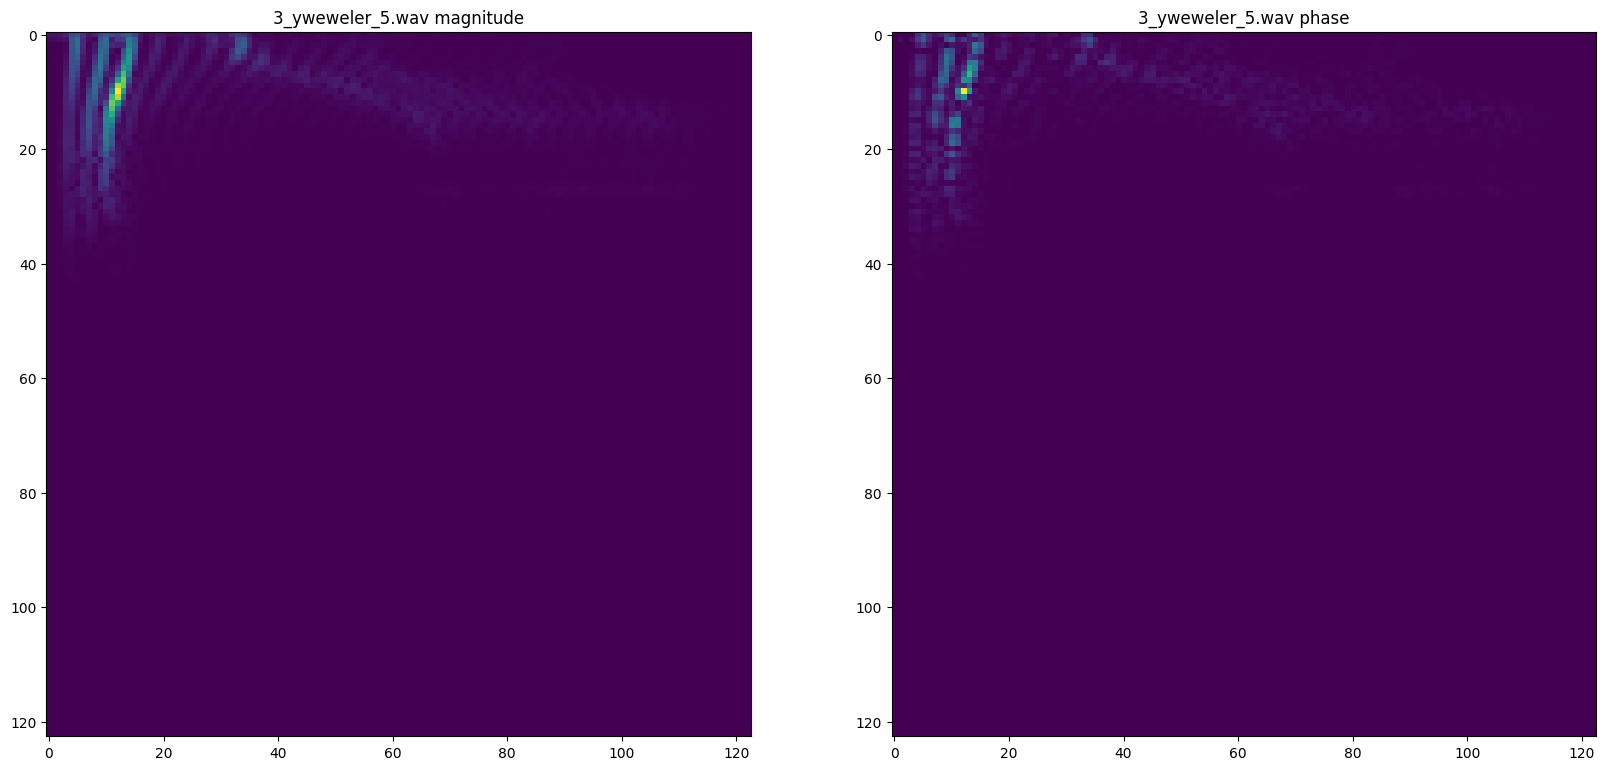

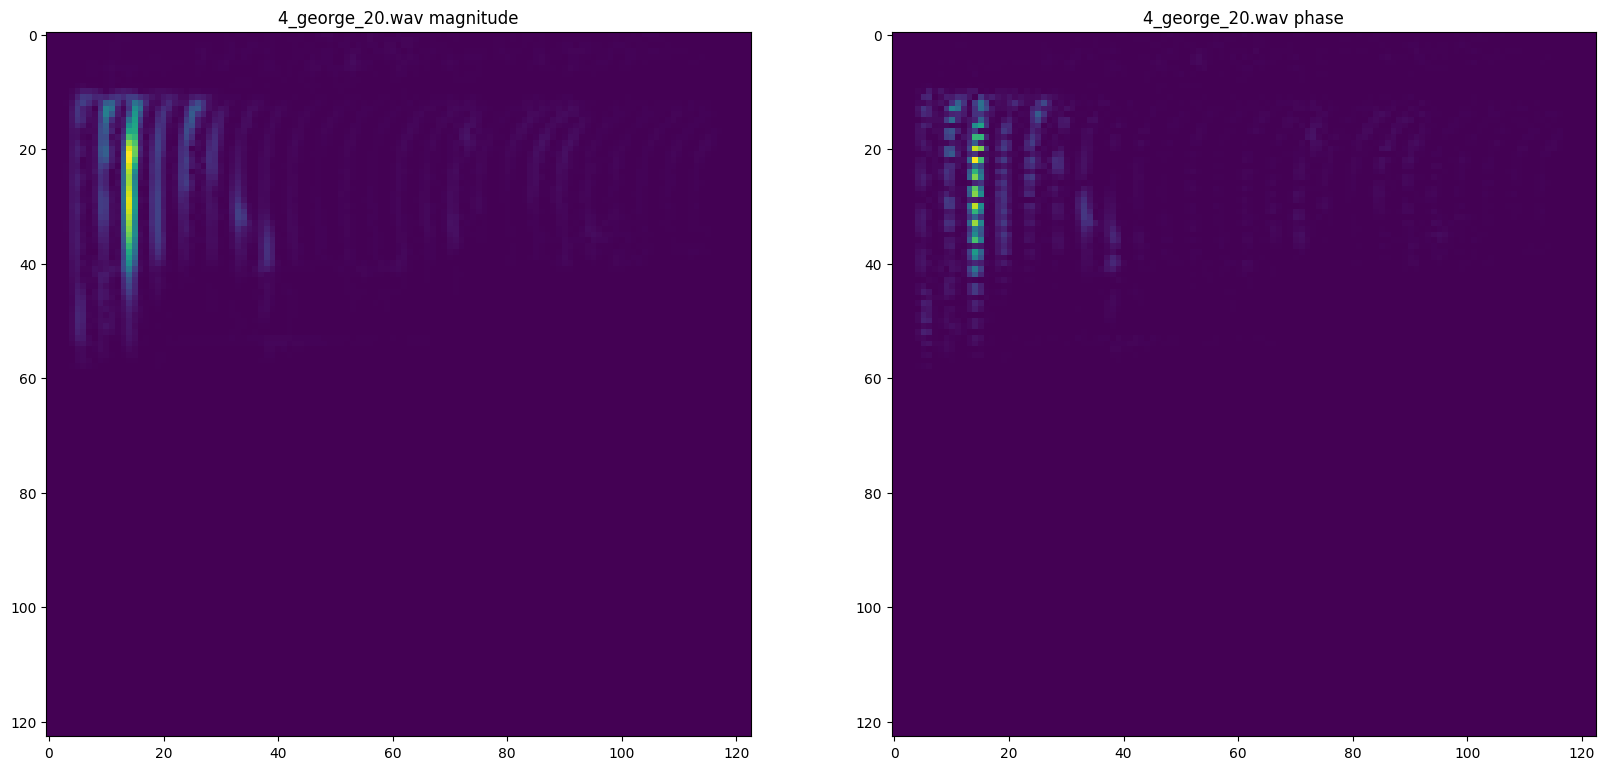

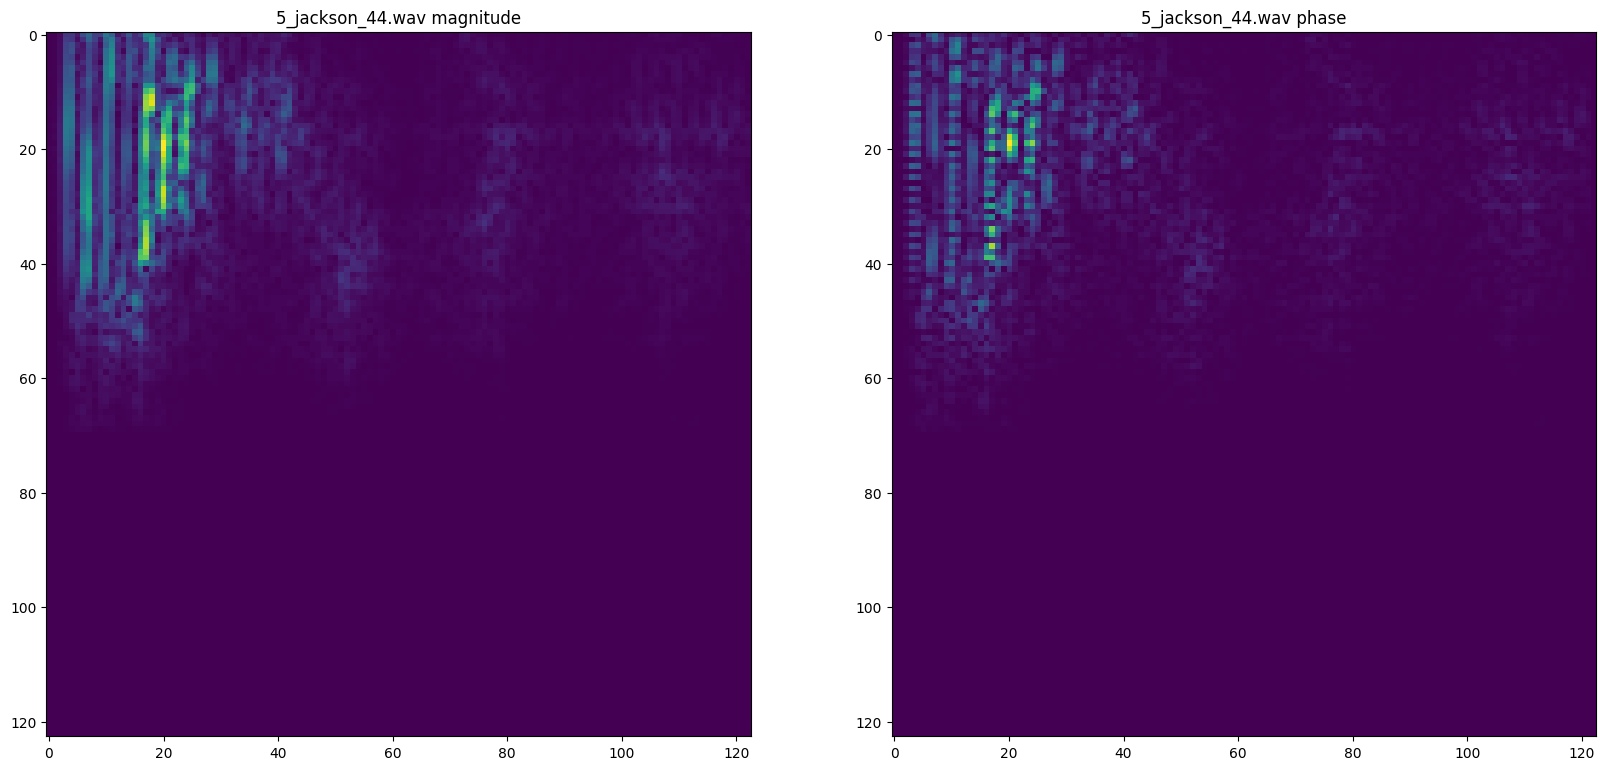

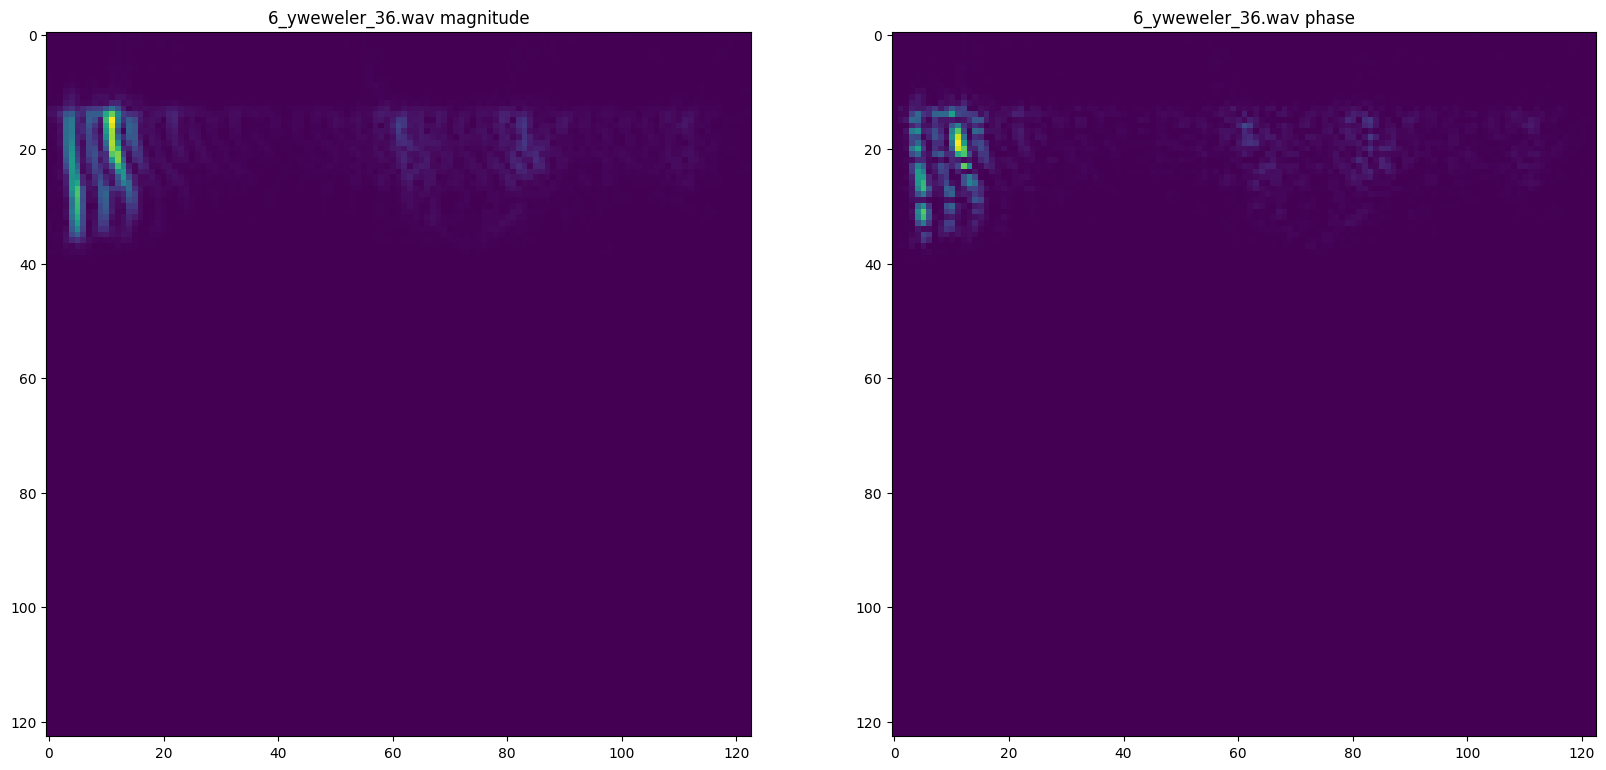

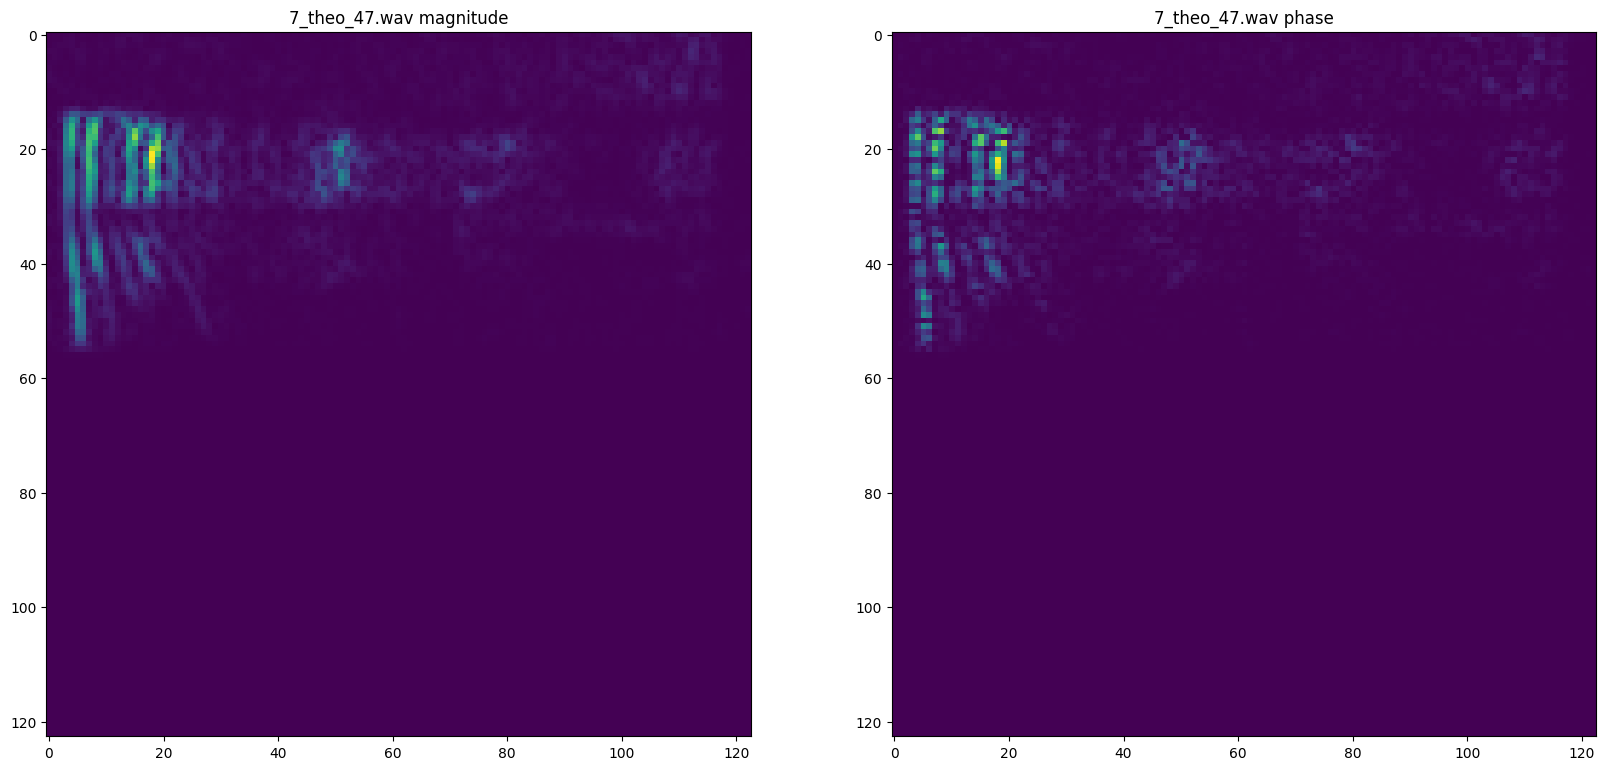

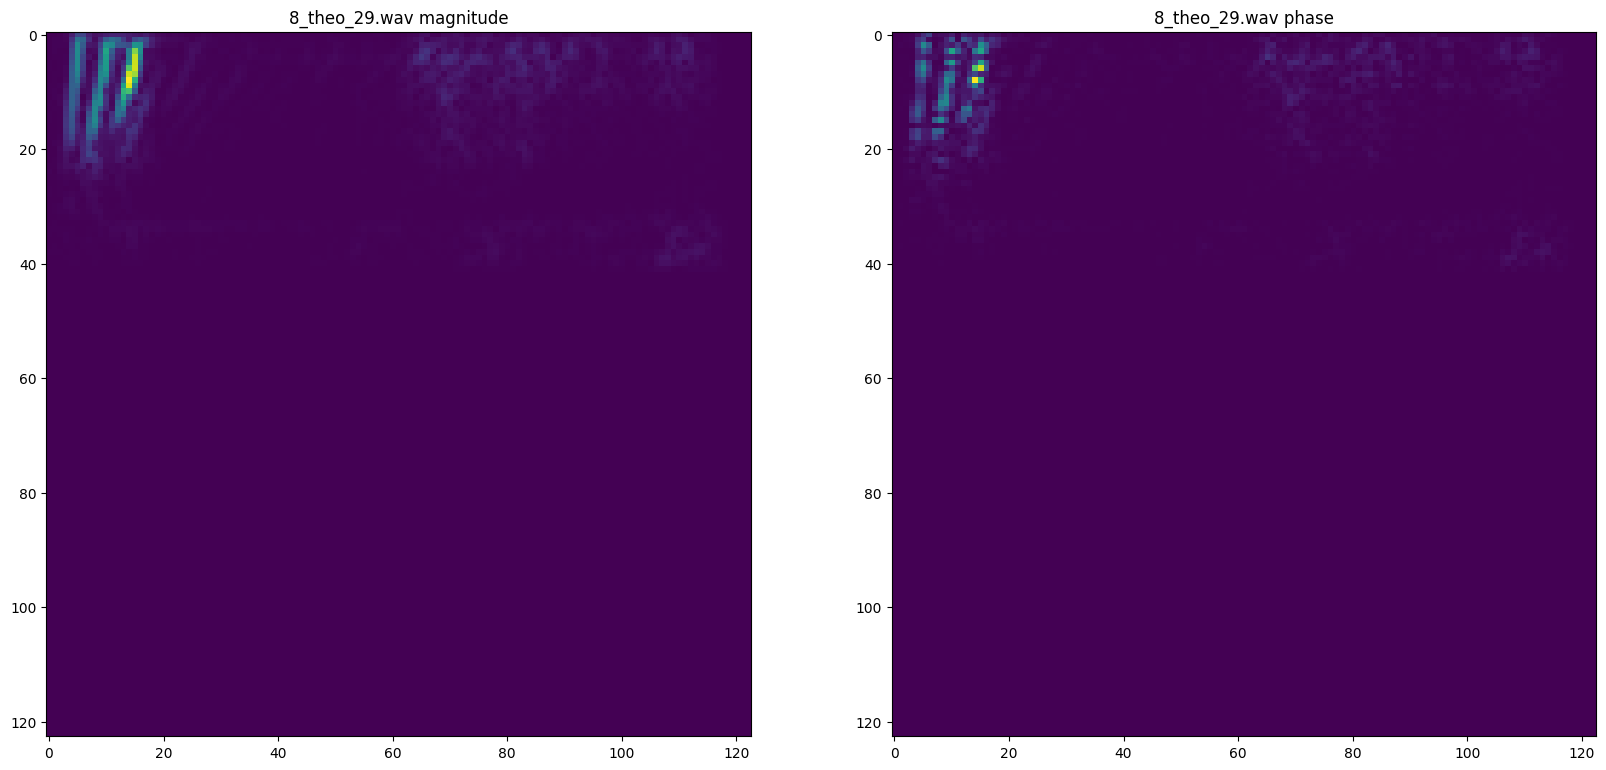

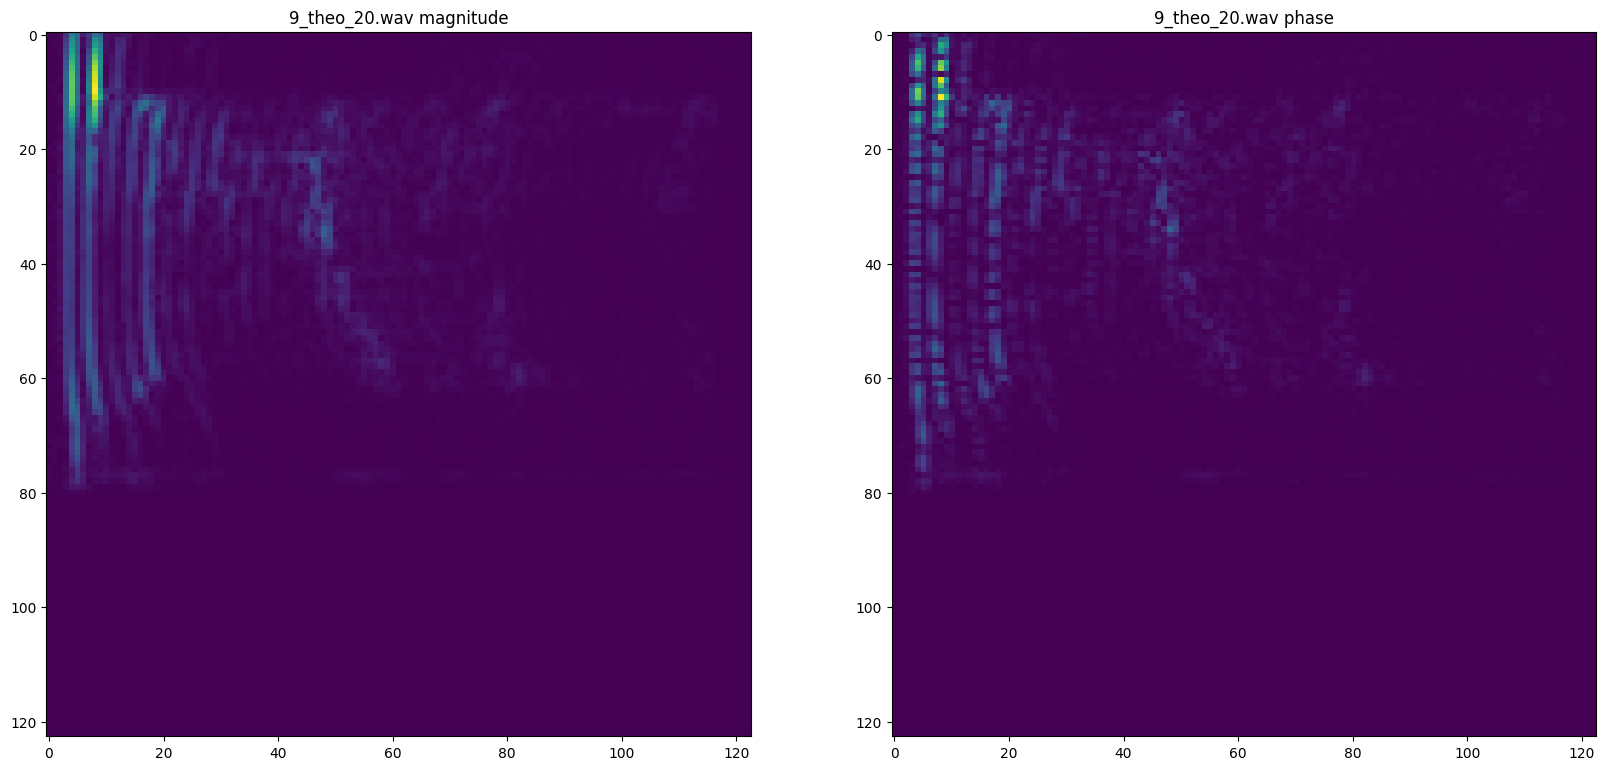

In [20]:
# Display all spectograms
frame_length=255
frame_step=55
fft_length = 244

for digit in range(10):
    fig, ax = plt.subplots(ncols=2,nrows=1, figsize=(20,20))
    data = tf.cast(samples[digit][2]['audio'],tf.float64)
    name = samples[digit][2]['audio/filename'].numpy().decode('utf-8')
    stft = tf.signal.stft(data,frame_length,frame_step,fft_length=fft_length)
    magnitude = tf.abs(stft)
    phase = tf.abs(tf.math.imag(stft))
    ax[0].imshow(magnitude.numpy())
    ax[0].set_title(name+' magnitude')
    ax[1].imshow(phase.numpy())
    ax[1].set_title(name+' phase')
    fig.show()
    

In [21]:
# Retrieve audio data and play it
sample_waveform = samples[7][2]['audio']
Audio(sample_waveform,rate=8000)

In [22]:
# Now transform it into a spectogram
stft = tf.signal.stft(tf.cast(sample_waveform,tf.float64),frame_length,frame_step,fft_length)

# Separate magnitude and phase into different channels
spectrogram_data = tf.stack([tf.math.real(stft),tf.math.imag(stft)],axis=2)
spectrogram_data.shape

TensorShape([123, 123, 2])

In [23]:
# Pad up to dims 132 * 132, and scale
paddings = tf.constant([[0,4],[0,3],[0,0]])
spectrogram_padded = spectrogram_data/data_max
print(spectrogram_padded.shape)

(123, 123, 2)


In [24]:
# Now recombine back into single spectrogram and transform back into audio
stft_reconstructed = tf.dtypes.complex(spectrogram_padded[:,:,0],spectrogram_padded[:,:,1])

inverse_stft = tf.signal.inverse_stft(
    stft_reconstructed,
    frame_length,
    frame_step,
    fft_length=fft_length,
    window_fn=tf.signal.inverse_stft_window_fn(frame_step))

Audio(inverse_stft,rate=8000)

The above demsonstrates the the Short Time Fourier Transformation is revetable, and therefore enables us to reconstruct the audio from the spectrograms.

#### Data Pre-processing

Based on the findings above, I have constructed the pre-processing steps below. First, I split the dataset into training and validation sets, per the guidence given [here](https://github.com/Jakobovski/free-spoken-digit-dataset); "Recordings numbered `0-4` (Recordings numbered `0-4` (inclusive) are in the test and `5-49` are in the training set."

In [25]:
# Split the datasets into train and test based on the file name
train_ds = ds_filtered.filter(lambda x: tf.strings.to_number(tf.strings.split(tf.strings.split(x['audio/filename'],sep='_')[2],sep='.')[0])>4)
val_ds = ds_filtered.filter(lambda x: tf.strings.to_number(tf.strings.split(tf.strings.split(x['audio/filename'],sep='_')[2],sep='.')[0])<=4)

In [26]:
# Select the audio data only, convert to float32, and rpad it to the length of 18300 from the data exploration stage
def extract_audio(elem):
    out = tf.cast(elem['audio'],tf.float32)
    out = tf.concat([out,tf.zeros(7000 - tf.shape(out)[0],tf.float32)],0)/data_max
    return out

train_ds = train_ds.map(extract_audio)
val_ds = val_ds.map(extract_audio)

In [27]:
# Convert the data into spectrograms with the above frame length and frame step
frame_length=255
frame_step=55
fft_length = 244

def get_spectrograms(elem):
    stft = tf.signal.stft(elem,frame_length,frame_step,fft_length=fft_length)
    out = tf.stack([tf.math.real(stft),tf.math.imag(stft)],axis=2)
    return out

train_ds = train_ds.map(get_spectrograms)
val_ds = val_ds.map(get_spectrograms)

In [28]:
# Make sure we got the right shape
for elem in train_ds.take(1):
    print(elem.shape)

(123, 123, 2)


In [29]:
# Pad both datasets to get to a multiple of 4
def pad_spectrograms(elem):
    padding = tf.constant([[0,1],[0,1],[0,0]])
    out = tf.pad(elem,padding)
    return out

train_ds=train_ds.map(pad_spectrograms)
val_ds=val_ds.map(pad_spectrograms)

In [30]:
# Shuffle the training set
train_ds = train_ds.shuffle(30)

# Batch training and validation set
train_ds = train_ds.batch(50,drop_remainder=True) # Dropping remainder because the model restore callback will throw an error otherwise
val_ds = val_ds.batch(50)

In [31]:
# Check shape
for batch in train_ds.take(1):
    print(batch.shape)

(50, 124, 124, 2)


In [32]:
# Work out the variance for the trainig set
train_numpy = np.array([])
for elem in train_ds.as_numpy_iterator():
    train_numpy = np.concatenate([train_numpy,elem.flatten()])
train_var = np.var(train_numpy)

In [33]:
# Prefetch training set
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

In [34]:
# Define function for converting the spectrograms back to waveforms
def spect_to_waveform(spectrogram,frame_length=frame_length, frame_step=frame_step,fft_length=fft_length):
    stft_reconstructed = tf.dtypes.complex(spectrogram[...,0],spectrogram[...,1])
    inverse_stft = tf.signal.inverse_stft(
        stft_reconstructed,
        frame_length,
        frame_step,
        fft_length=fft_length,
        window_fn=tf.signal.inverse_stft_window_fn(frame_step))
    return inverse_stft

### Question 2 (Total 25 marks)

a) In the VQ-VAE, the variational posterior output by the encoder is deterministic:

$$q_\phi(z = e_k \mid x) = \left\{
\begin{array}{l}
~1 \quad\textrm{for}\quad k=\underset{j}{\arg\min} ||E(x) - e_j||\\
~0 \quad\textrm{otherwise}
\end{array}
\right.
$$

where in the above, $\phi$ represents the parameters of the encoder. Show that by choosing a simple uniform distribution over the codebook vectors $e_i$ as the prior distribution $p(z)$, the KL-divergence term of the ELBO objective is equal to a constant.

**(5 marks)**

Since we are choosing a simple uniform distribution over the codebook vectors $e_i$, this entails:
$$
\forall k, p(z=e_k) = \frac{1}{K}
$$

Solving for the KL divergence term in the ELBO loss, we have:

$$
D_{KL}(q_{\phi}(z|x)||p(z)) = \mathbb{E}_{q_\phi}\left[\log \frac{q_{\phi}(z|x)}{p(z)}\right] 
= \sum_{k=1}^{K}\log \frac{q_{\phi}(z=e_k|x)}{p(z=e_k)}q_{\phi}(z=e_k|x)
= \log (\frac{1}{1/K} \cdot 1)
=\log (K)
$$

b) The VQ-VAE as described above has an implementation that is available on the Keras website [here](https://keras.io/examples/generative/vq_vae/). In particular, the implementation of the vector quantisation and addition of the codebook and commitment loss is done with the `VectorQuantizer` layer.

You should write your own custom Layer class that is based on the `VectorQuantizer` layer, but with the following amendments:

1) The codebook loss should be removed, and instead the layer should use exponential moving average updates for the codebook during training, as follows:
$$
N_i^{(t)} := N_i^{(t-1)} * \gamma + n_i^{(t)}(1 - \gamma),\quad m_i^{(t)} := m_i^{(t-1)} * \gamma + \sum_j^{n_i^{(t)}} E(x)_{i,j}^{(t)}(1-\gamma),\quad e_i^{(t)} :=\frac{m_i^{(t)}}{N_i^{(t)}},\qquad i=1,\ldots,K
$$
where $n_i^{(t)}$ is the number of vectors in $E(x)$ in the minibatch that are quantized to codebook vector $e_i$ (cluster size), and $0 < \gamma < 1$ is a decay parameter, normally set to $\gamma=0.99$ as default. The moving averages are typically initialised as $m_i^{(0)} = e_i^{(0)}$ and $N_i^{(0)} = 0$. Note that the above update is independent of the gradient-based optimizer used to update the parameters of the encoder and decoder networks.

2) In place of the (single) codebook vector quantisation, your custom Layer class should use _residual vector quantisation_ (RVQ). This is a multi-stage vector quantiser, which involves $N_q$ layers of vector quantisation as follows. Define a sequence of codebooks $\mathbf{e}^{(j)}\in\mathbb{R}^{K\times D}$, $j=1,\ldots,N_q$. Codebook $\mathbf{e}^{(j)}$ consists of $K$ latent embedding vectors $e_i^{(j)}$, each of dimension $D$ as before.

The encoder output $E(x)$ is first quantised using the first codebook:

$$VQ^{(1)}(E(x)) = e_k^{(1)},\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j^{(1)}||_2,$$
    
The residual $\hat{e}^{(1)} := E(x) - VQ^{(1)}(E(x))$ is then quantised using the second codebook to give $VQ^{(2)}(\hat{e}^{(1)})$, and so on. The RVQ layer then sends the sum of the quantised vectors on to the decoder. The algorithm is summarised in the following pseudocode.

<img src="figures/rvq_pseudocode.png" alt="RVQ pseudocode" style="width: 450px;"/>

**(15 marks)**

In [35]:
class VectorQuantizer(Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized,encoding_indices,encodings,input_shape

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [47]:
class RVQVectorQuantizer(Layer):
    def __init__(self, num_embeddings, embedding_dim, rvq_layers=1, beta=0.25, gamma=0.99, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.rvq_layers = rvq_layers

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # The gamma parameter will be set to 0.99 as per the instructions
        self.gamma = gamma
        
        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings, self.rvq_layers), dtype="float32"
            ),
            trainable=False, # Per the insinuation in the question, now updates independantly of the gradient optimization
            name="embeddings_rvqvae",
        )

        # Initialize cluster counts
        N_init = tf.zeros_initializer()
        self.N = tf.Variable(
            initial_value = N_init(
                shape = (self.num_embeddings,self.rvq_layers), dtype="float32"
            ),
            trainable=False,
            name="cluster_count_rvqvae"
        )

        # Initialize the encoding sum
        self.m = tf.Variable(
            initial_value = self.embeddings,
            trainable=False,
            name="encoding_sum_rvqvae"
        )
        
    def call(self, x, training=None):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Residual Vector Quantization
        quantized = tf.zeros(tf.shape(flattened))
        residual = flattened
        encoding_list = []
        update_list = []
        for layer in range(self.rvq_layers):
            encoding_indices = self.get_code_indices(residual,layer)
            encodings = tf.one_hot(encoding_indices, self.num_embeddings)
            encoding_list.append(encodings)
            update = tf.matmul(encodings, self.embeddings[...,layer], transpose_b=True)
            update_list.append(update)
            quantized+=update
            residual-=update

        # Exponential moving average updates to the embeddings during training
        if training:
            encodings = tf.stack(encoding_list,axis=-1)
            quantizations = tf.stack(update_list,axis=-1)
            n = tf.math.reduce_sum(encodings,axis=0)

            m_list = []
            for layer in range(self.rvq_layers):
                E_sum = tf.matmul(quantizations[...,layer],encodings[...,layer],transpose_a=True)
                m_list.append(self.gamma*self.m[...,layer] + (1 - self.gamma)*E_sum)
            
            N_update = self.gamma*self.N + (1 - self.gamma)*n
            m_update = tf.stack(m_list,axis=-1)

            self.N.assign(N_update)
            self.m.assign(m_update)
            embedding_update = tf.math.multiply(self.m,tf.math.reciprocal_no_nan(self.N))
            self.embeddings.assign(embedding_update)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        self.add_loss(self.beta * commitment_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs,layer):
        # Calculate L2-normalized distance between the inputs and the codes.
        embeddings = self.embeddings[...,layer]
        similarity = tf.matmul(flattened_inputs, embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

c) Test your custom vector quantisation layer above by training a simple model on MNIST and displaying a few reconstructions of the model.

**(5 marks)**

For the implementation below, I follow the example from the keras website [here](https://keras.io/examples/generative/vq_vae/)

In [45]:
# Define functions for the encoder and decoder
def get_encoder(latent_dim=16,input_shape=(28,28,1)):
    encoder_inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = Conv2D(latent_dim, 1, padding="same")(x)
    return Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16,input_shape = (28,28,1)):
    latent_inputs = Input(shape=get_encoder(latent_dim,input_shape).output.shape[1:])
    x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = Conv2DTranspose(input_shape[2], 3, padding="same")(x)
    return Model(latent_inputs, decoder_outputs, name="decoder")

In [49]:
# Define function to compose the RVQ-VAE model
def get_rvqvae(input_shape=(28,28,1),latent_dim=16, num_embeddings=64,rvq_layers=3,gamma=0.99,beta=0.25):
    rvq_layer = RVQVectorQuantizer(num_embeddings, latent_dim, rvq_layers, name="residual_vector_quantizer",gamma=gamma,beta=beta)
    encoder = get_encoder(latent_dim,input_shape)
    decoder = get_decoder(latent_dim,input_shape)
    inputs = Input(shape=input_shape)
    encoder_outputs = encoder(inputs)
    quantized_latents = rvq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return Model(inputs, reconstructions, name="rvq_vae")

In [79]:
# Display the summary
get_rvqvae().summary()

Model: "rvq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 residual_vector_quantizer   (None, 7, 7, 16)          6336      
 (RVQVectorQuantizer)                                            
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 54225 (211.82 KB)
Trainable params: 47889 (187.07 KB)
Non-trainable params: 6336 (24.75 KB)
_________________________________________________________________


Here, I adapt the RVQVAE Trainer object from the Keras website, and include a training function. Note that this object does not make use of Tensorflow probability. It calculates the losses deterministically by Monte Carlo sampling. For this, it requires the data variance as an input.

In [80]:
# Wrap training loop in RVQVAETrainer
class RVQVAETrainer(Model):
    def __init__(self, train_variance,shape=(28,28,1), latent_dim=32, num_embeddings=128, rvq_layers=3,gamma=0.99,beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.rvq_layers = rvq_layers
        self.shape = shape
        self.rvqvae = get_rvqvae(self.shape,self.latent_dim, self.num_embeddings, self.rvq_layers,gamma=gamma,beta=beta)

        self.total_loss_tracker = Mean(name="loss")
        self.reconstruction_loss_tracker = Mean(
            name="reconstruction_loss"
        )
        self.rvq_loss_tracker = Mean(name="rvqvae_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.rvq_loss_tracker
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the RVQ-VAE.
            reconstructions = self.rvqvae(x,training=True)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.rvqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.rvqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.rvqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.rvq_loss_tracker.update_state(sum(self.rvqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "rvqvae_loss": self.rvq_loss_tracker.result(),
        }

    def test_step(self,x):
        # Get the outputs from the RVQ-VAE model
        reconstructions = self.rvqvae(x)

        # Calculate the losses
        reconstruction_loss = (
            tf.reduce_mean((x - reconstructions)**2/self.train_variance) # Monte Carlo estimate of E[p(x|z)], assuming Normal p(x|z)
        )
        rvqvae_loss = sum(self.rvqvae.losses)
        total_loss = reconstruction_loss + rvqvae_loss

        # Loss tracking
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.rvq_loss_tracker.update_state(rvqvae_loss)

        # Log results
        return {
            "loss":self.total_loss_tracker.result(),
            "reconstruction_loss":self.reconstruction_loss_tracker.result(),
            "rvqvae_loss":self.rvq_loss_tracker.result()
        }


In [81]:
# Load and process the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

In [82]:
rvqvae_trainer = RVQVAETrainer(data_variance,shape=(28,28,1),latent_dim=16,num_embeddings=128,rvq_layers=5)
rvqvae_trainer.compile(optimizer=tf.keras.optimizers.Adam())
mnist_hist = rvqvae_trainer.fit(x_train_scaled,epochs=30,batch_size=128)

Epoch 1/30
469/469 [==============================] - 5s 5ms/step - loss: 0.2083 - reconstruction_loss: 0.1891 - rvqvae_loss: 0.0192
Epoch 2/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0635 - reconstruction_loss: 0.0421 - rvqvae_loss: 0.0213
Epoch 3/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0502 - reconstruction_loss: 0.0319 - rvqvae_loss: 0.0183
Epoch 4/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0457 - reconstruction_loss: 0.0277 - rvqvae_loss: 0.0180
Epoch 5/30
469/469 [==============================] - 3s 5ms/step - loss: 0.0440 - reconstruction_loss: 0.0255 - rvqvae_loss: 0.0185
Epoch 6/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0431 - reconstruction_loss: 0.0242 - rvqvae_loss: 0.0189
Epoch 7/30
469/469 [==============================] - 2s 5ms/step - loss: 0.0407 - reconstruction_loss: 0.0222 - rvqvae_loss: 0.0184
Epoch 8/30
469/469 [==============================] - 2s 5ms/step - l

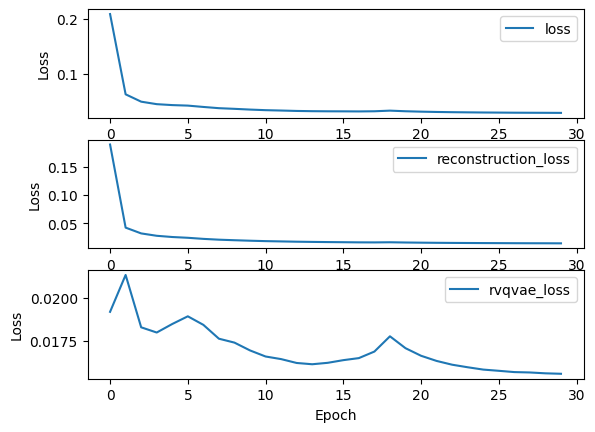

In [83]:
# Visualise the training and validation losses
fig, ax = plt.subplots(nrows=3,ncols=1)
metrics = ['loss','reconstruction_loss','rvqvae_loss']
for i in range(len(metrics)):
    ax[i].plot(mnist_hist.history[metrics[i]],label = metrics[i])
    #ax[i].plot(mnist_hist.history["val_"+metrics[i]],label = "val_"+metrics[i])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss')
    ax[i].legend()
fig.show()

1/1 [==============================] - 0s 304ms/step


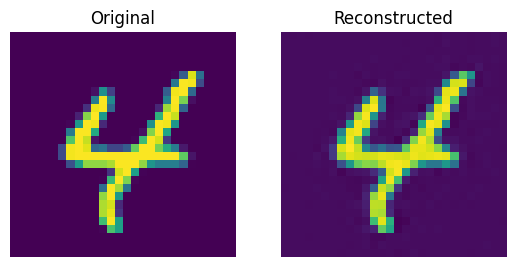

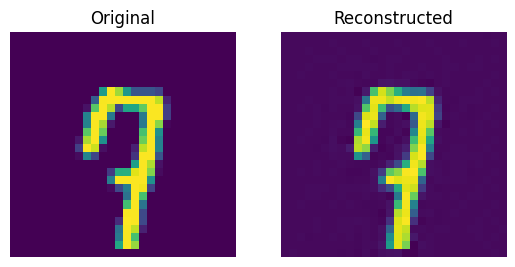

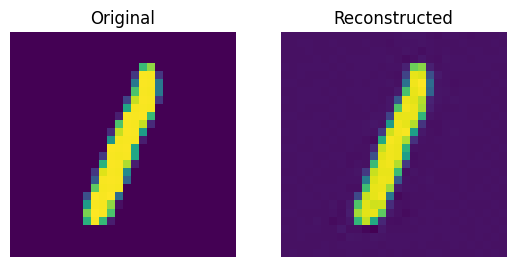

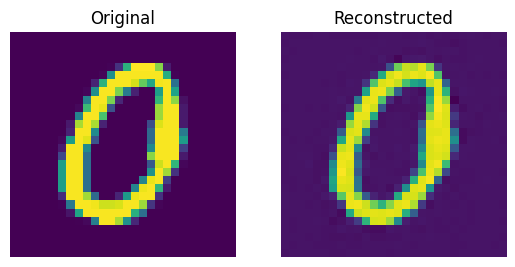

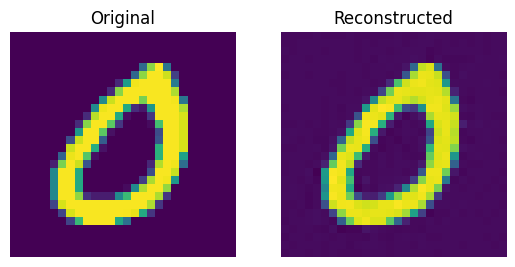

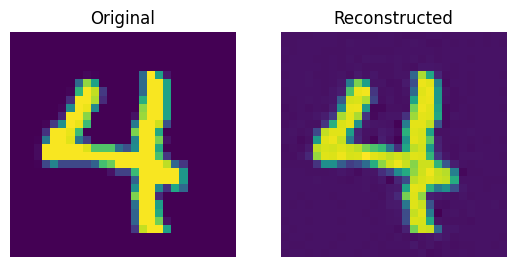

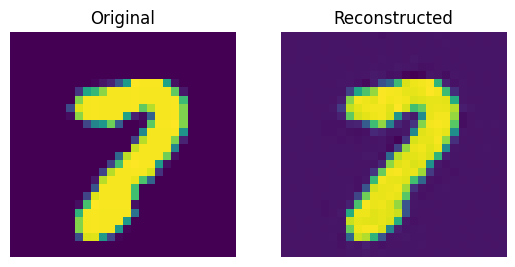

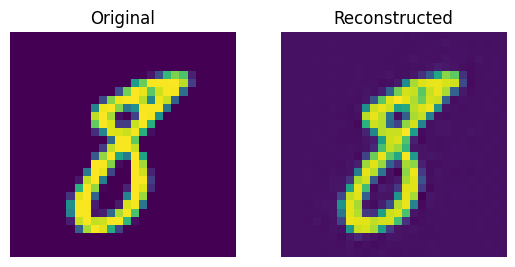

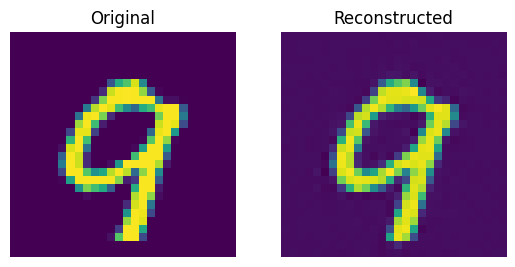

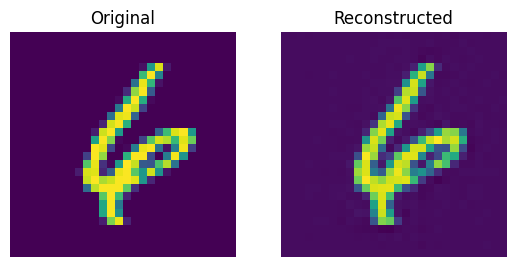

In [84]:
# Reconstruction results on the test set
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_rvqvae_model = rvqvae_trainer.rvqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_rvqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

### Question 3 (Total 40 marks)

a) Design, implement and train a VQ-VAE for the spoken digit dataset. You are free to choose any architecture for the encoder and decoder networks, but your model should use the custom RVQ layer from question 2, with $N_q\ge2$ codebooks. (If you have been unable to implement this custom layer, then you should use the `VectorQuantizer` layer from the [Keras website](https://keras.io/examples/generative/vq_vae/)). You can also make additions or modifications to the training algorithm if you wish.

Your trained model should output a sequence of codebook vectors using the encoder and RVQ layer, which are then decoded by the decoder network to reconstruct the original input.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best experiment only.

Display some examples (playable using the `Audio` class from the `IPython.display` module as in question 1) from the dataset along with their reconstructions to demonstrate the trained model.

**(25 marks)**

In [85]:
# Make  model checkpoint directory
path_checkpoints = "model_checkpoints"
if not os.path.exists(path_checkpoints):
    os.makedirs(path_checkpoints)
    
# Make model backup directory
path_backup = "model_backup"
if not os.path.exists(path_backup):
    os.makedirs(path_backup)

# Make log directory
path_log  = "training_logs"
if not os.path.exists(path_log):
    os.makedirs(path_log)

In [86]:
# Make  model checkpoint directory
path_checkpoints = "model_checkpoints/q3a"
if not os.path.exists(path_checkpoints):
    os.makedirs(path_checkpoints)
    
# Make model backup directory
path_backup = "model_backup/q3a"
if not os.path.exists(path_backup):
    os.makedirs(path_backup)

#### Model 1: Same as above

In [87]:
# First, I will implement the same infrastructure as in the previous section to check how things work
get_rvqvae(input_shape=(124, 124, 2)).summary()

Model: "rvq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 124, 124, 2)]     0         
                                                                 
 encoder (Functional)        (None, 31, 31, 16)        20144     
                                                                 
 residual_vector_quantizer   (None, 31, 31, 16)        6336      
 (RVQVectorQuantizer)                                            
                                                                 
 decoder (Functional)        (None, 124, 124, 2)       28322     
                                                                 
Total params: 54802 (214.07 KB)
Trainable params: 48466 (189.32 KB)
Non-trainable params: 6336 (24.75 KB)
_________________________________________________________________


In [88]:
# Make  model checkpoint directory
path_checkpoints_1 = "model_checkpoints/q3a/model_1"
if not os.path.exists(path_checkpoints):
    os.makedirs(path_checkpoints)
    
# Make model backup directory
path_backup_1 = "model_backup/q3a/model_1"
if not os.path.exists(path_backup):
    os.makedirs(path_backup)

In [95]:
# Define callback for Backing up and restoring training state in case of interruption
backup_restore = tf.keras.callbacks.BackupAndRestore(path_backup_1)

# Define callback for logging training results
csv_logging = tf.keras.callbacks.CSVLogger('training_logs/model_1.csv',append=True) #Setting append to true in case of interruptions

# Define callback for saving the model on epoch end
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_checkpoints_1+"/epoch_{epoch}.weights.h5",
    save_best_only=False,
    save_weights_only=True
)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=10)

# Define adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

In [96]:
# Compile and fit the model
rvqvae_trainer = RVQVAETrainer(train_var,shape=(124,124,2),latent_dim=16,num_embeddings=128,rvq_layers=5)
rvqvae_trainer.compile(optimizer=optimizer)

In [97]:
# Delete log file if it exists
if os.path.exists('training_logs/model_1.csv'):
    os.remove('training_logs/model_1.csv')

In [98]:
# Empty out checkpoint directory if exists
for file in os.listdir(path_checkpoints_1):
    if os.path.isfile(path_checkpoints_1+'/'+file):
        os.remove(path_checkpoints_1+'/'+file)

In [99]:
model_1_hist = rvqvae_trainer.fit(
    train_ds,
    validation_data = val_ds,
    epochs=40,
    callbacks=[backup_restore,csv_logging,model_checkpoints]
)

Epoch 1/40
     42/Unknown - 9s 146ms/step - loss: 0.9745 - reconstruction_loss: 0.9732 - rvqvae_loss: 0.0014

2024-04-22 21:21:07.362932: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8685872279459225373
2024-04-22 21:21:07.363005: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7800453653822214903
2024-04-22 21:21:07.363013: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4250116174535423947
2024-04-22 21:21:08.738415: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10618297329809903988


44/44 [==============================] - 11s 180ms/step - loss: 0.9830 - reconstruction_loss: 0.9815 - rvqvae_loss: 0.0016 - val_loss: 0.8692 - val_reconstruction_loss: 0.8631 - val_rvqvae_loss: 0.0061
Epoch 2/40
44/44 [==============================] - 8s 173ms/step - loss: 0.8306 - reconstruction_loss: 0.8066 - rvqvae_loss: 0.0240 - val_loss: 0.7162 - val_reconstruction_loss: 0.6707 - val_rvqvae_loss: 0.0455
Epoch 3/40
44/44 [==============================] - 8s 174ms/step - loss: 0.7386 - reconstruction_loss: 0.6823 - rvqvae_loss: 0.0563 - val_loss: 0.6683 - val_reconstruction_loss: 0.5897 - val_rvqvae_loss: 0.0787
Epoch 4/40
44/44 [==============================] - 8s 174ms/step - loss: 0.6932 - reconstruction_loss: 0.6096 - rvqvae_loss: 0.0836 - val_loss: 0.6283 - val_reconstruction_loss: 0.5282 - val_rvqvae_loss: 0.1001
Epoch 5/40
44/44 [==============================] - 8s 172ms/step - loss: 0.6602 - reconstruction_loss: 0.5579 - rvqvae_loss: 0.1024 - val_loss: 0.6194 - val_reco

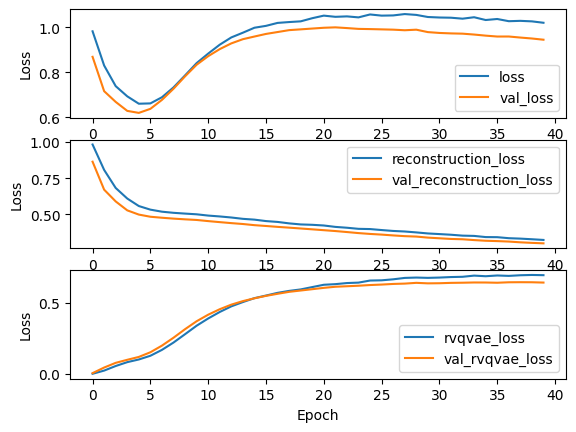

In [100]:
# Visualise the training and validation losses
fig, ax = plt.subplots(nrows=3,ncols=1)
metrics = ['loss','reconstruction_loss','rvqvae_loss']
for i in range(len(metrics)):
    ax[i].plot(model_1_hist.history[metrics[i]],label = metrics[i])
    ax[i].plot(model_1_hist.history["val_"+metrics[i]],label = "val_"+metrics[i])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss')
    ax[i].legend()
fig.show()

In [101]:
# Reconstruct some of the audio clips form the validation data
for elem in val_ds.take(1):
    val_batch = elem

In [102]:
# Test function
audio = spect_to_waveform(val_batch[0])
Audio(audio,rate=8000)

In [106]:
trained_model_1 = rvqvae_trainer.rvqvae

In [107]:
pred_spects = trained_model_1.predict(val_batch)

2/2 [==============================] - 0s 5ms/step


In [108]:
pred_audio = spect_to_waveform(pred_spects[0])
Audio(pred_audio,rate=8000)

This is ok, but from the training curve, this model took a very long time to train, and it seems as if the embeddings are initializing badly. One possible remidy is to initialize the embeddings with the glorot normal initializer, which I will implement below.

#### Model 2

In [101]:
# Make  model checkpoint directory
path_checkpoints_2 = "model_checkpoints/q3a/model_2"
if not os.path.exists(path_checkpoints_2):
    os.makedirs(path_checkpoints_2)
    
# Make model backup directory
path_backup_2 = "model_backup/q3a/model_2"
if not os.path.exists(path_backup_2):
    os.makedirs(path_backup_2)

In [102]:
# Define callback for Backing up and restoring training state in case of interruption
backup_restore_2 = tf.keras.callbacks.BackupAndRestore(path_backup_2)

# Define callback for logging training results
csv_logging_2 = tf.keras.callbacks.CSVLogger('training_logs/model_2.csv',append=True) #Setting append to true in case of interruptions

# Define callback for saving the best model
model_checkpoints_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_checkpoints_2+"/epoch_{epoch}.weights.h5",
    save_best_only=False,
    save_weights_only=True
)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=10)

# Define adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

In [103]:
class RVQVectorQuantizer2(Layer):
    def __init__(self, num_embeddings, embedding_dim, rvq_layers=1, beta=0.25, gamma=0.99, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.rvq_layers = rvq_layers

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # The gamma parameter will be set to 0.99 as per the instructions
        self.gamma = gamma
        
        # Initialize the embeddings which we will quantize.
        w_init = tf.keras.initializers.GlorotNormal()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings, self.rvq_layers), dtype="float32"
            ),
            trainable=False, # Per the insinuation in the question, now updates independantly of the gradient optimization
            name="embeddings_rvqvae",
        )

        # Initialize cluster counts
        N_init = tf.zeros_initializer()
        self.N = tf.Variable(
            initial_value = N_init(
                shape = (self.num_embeddings,self.rvq_layers), dtype="float32"
            ),
            trainable=False,
            name="cluster_count_rvqvae"
        )

        # Initialize the encoding sum
        self.m = tf.Variable(
            initial_value = self.embeddings,
            trainable=False,
            name="encoding_sum_rvqvae"
        )
        
    def call(self, x, training=None):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Residual Vector Quantization
        quantized = tf.zeros(tf.shape(flattened))
        residual = flattened
        encoding_list = []
        update_list = []
        for layer in range(self.rvq_layers):
            encoding_indices = self.get_code_indices(residual,layer)
            encodings = tf.one_hot(encoding_indices, self.num_embeddings)
            encoding_list.append(encodings)
            update = tf.matmul(encodings, self.embeddings[...,layer], transpose_b=True)
            update_list.append(update)
            quantized+=update
            residual-=update

        # Exponential moving average updates to the embeddings during training
        if training:
            encodings = tf.stack(encoding_list,axis=-1)
            quantizations = tf.stack(update_list,axis=-1)
            n = tf.math.reduce_sum(encodings,axis=0)

            m_list = []
            for layer in range(self.rvq_layers):
                E_sum = tf.matmul(quantizations[...,layer],encodings[...,layer],transpose_a=True)
                m_list.append(self.gamma*self.m[...,layer] + (1 - self.gamma)*E_sum)
            
            N_update = self.gamma*self.N + (1 - self.gamma)*n
            m_update = tf.stack(m_list,axis=-1)

            self.N.assign(N_update)
            self.m.assign(m_update)
            embedding_update = tf.math.multiply(self.m,tf.math.reciprocal_no_nan(self.N))
            self.embeddings.assign(embedding_update)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        self.add_loss(self.beta * commitment_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs,layer):
        # Calculate L2-normalized distance between the inputs and the codes.
        embeddings = self.embeddings[...,layer]
        similarity = tf.matmul(flattened_inputs, embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [105]:
# Define function to compose the RVQ-VAE model
def get_rvqvae2(input_shape=(28,28,1),latent_dim=16, num_embeddings=64,rvq_layers=3):
    rvq_layer = RVQVectorQuantizer2(num_embeddings, latent_dim, rvq_layers, name="residual_vector_quantizer")
    encoder = get_encoder(latent_dim,input_shape)
    decoder = get_decoder(latent_dim,input_shape)
    inputs = Input(shape=input_shape)
    encoder_outputs = encoder(inputs)
    quantized_latents = rvq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return Model(inputs, reconstructions, name="rvq_vae")

In [106]:
# Wrap training loop in RVQVAETrainer
class RVQVAETrainer2(Model):
    def __init__(self, train_variance,shape=(28,28,1), latent_dim=32, num_embeddings=128, rvq_layers=3, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.rvq_layers = rvq_layers
        self.shape = shape
        self.rvqvae = get_rvqvae2(self.shape,self.latent_dim, self.num_embeddings, self.rvq_layers)

        self.total_loss_tracker = Mean(name="loss")
        self.reconstruction_loss_tracker = Mean(
            name="reconstruction_loss"
        )
        self.rvq_loss_tracker = Mean(name="rvqvae_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.rvq_loss_tracker
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the RVQ-VAE.
            reconstructions = self.rvqvae(x,training=True)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.rvqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.rvqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.rvqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.rvq_loss_tracker.update_state(sum(self.rvqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "rvqvae_loss": self.rvq_loss_tracker.result(),
        }

    def test_step(self,x):
        # Get the outputs from the RVQ-VAE model
        reconstructions = self.rvqvae(x)

        # Calculate the losses
        reconstruction_loss = (
            tf.reduce_mean((x - reconstructions)**2/self.train_variance) # Monte Carlo estimate of E[p(x|z)], assuming Normal p(x|z)
        )
        rvqvae_loss = sum(self.rvqvae.losses)
        total_loss = reconstruction_loss + rvqvae_loss

        # Loss tracking
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.rvq_loss_tracker.update_state(rvqvae_loss)

        # Log results
        return {
            "loss":self.total_loss_tracker.result(),
            "reconstruction_loss":self.reconstruction_loss_tracker.result(),
            "rvqvae_loss":self.rvq_loss_tracker.result()
        }


In [107]:
# Delete the training log if it exists
if os.path.exists('training_logs/model_2.csv'):
    os.remove('training_logs/model_2.csv')

In [108]:
# Empty out checkpoint directory if exists
for file in os.listdir(path_checkpoints_2):
    if os.path.isfile(path_checkpoints_2+'/'+file):
        os.remove(path_checkpoints_2+'/'+file)

In [109]:
# Compile and fit the model
rvqvae_trainer2 = RVQVAETrainer2(train_var,shape=(124,124,2),latent_dim=16,num_embeddings=128,rvq_layers=5)
rvqvae_trainer2.compile(optimizer=optimizer,loss='loss')
model_2_hist = rvqvae_trainer2.fit(
    train_ds,
    validation_data = val_ds,
    epochs=40,
    callbacks=[backup_restore_2,csv_logging_2,model_checkpoints_2]
)

Epoch 1/40
     42/Unknown - 10s 146ms/step - loss: 0.9742 - reconstruction_loss: 0.9731 - rvqvae_loss: 0.0011   

2024-04-23 08:16:52.619384: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2201468848740434561
2024-04-23 08:16:52.619451: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11274712643991487265
2024-04-23 08:16:52.619481: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16886295498709020413
2024-04-23 08:16:54.116055: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7992562746274264507


44/44 [==============================] - 12s 183ms/step - loss: 0.9749 - reconstruction_loss: 0.9736 - rvqvae_loss: 0.0013 - val_loss: 0.8637 - val_reconstruction_loss: 0.8585 - val_rvqvae_loss: 0.0052
Epoch 2/40
44/44 [==============================] - 8s 175ms/step - loss: 0.8213 - reconstruction_loss: 0.7944 - rvqvae_loss: 0.0269 - val_loss: 0.6957 - val_reconstruction_loss: 0.6439 - val_rvqvae_loss: 0.0519
Epoch 3/40
44/44 [==============================] - 8s 173ms/step - loss: 0.7102 - reconstruction_loss: 0.6448 - rvqvae_loss: 0.0654 - val_loss: 0.6128 - val_reconstruction_loss: 0.5401 - val_rvqvae_loss: 0.0727
Epoch 4/40
44/44 [==============================] - 8s 172ms/step - loss: 0.6298 - reconstruction_loss: 0.5566 - rvqvae_loss: 0.0732 - val_loss: 0.5576 - val_reconstruction_loss: 0.4847 - val_rvqvae_loss: 0.0730
Epoch 5/40
44/44 [==============================] - 8s 173ms/step - loss: 0.5865 - reconstruction_loss: 0.5105 - rvqvae_loss: 0.0760 - val_loss: 0.5409 - val_reco

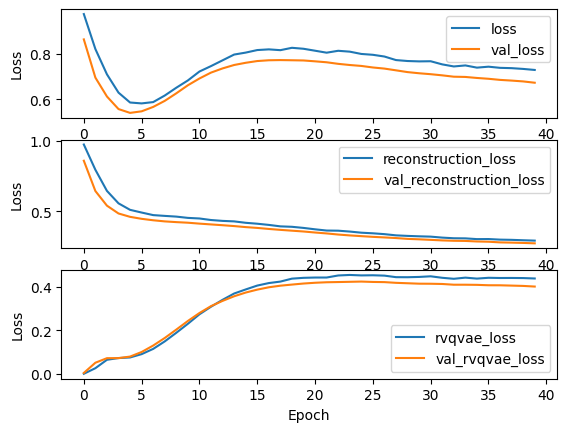

In [110]:
# Visualise the training and validation losses
fig, ax = plt.subplots(nrows=3,ncols=1)
metrics = ['loss','reconstruction_loss','rvqvae_loss']
for i in range(len(metrics)):
    ax[i].plot(model_2_hist.history[metrics[i]],label = metrics[i])
    ax[i].plot(model_2_hist.history["val_"+metrics[i]],label = "val_"+metrics[i])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss')
    ax[i].legend()
fig.show()

In [111]:
# Reconstruct some of the audio clips form the validation data
for elem in val_ds.take(1):
    val_batch = elem

In [112]:
# Test function
audio = spect_to_waveform(val_batch[0])
Audio(audio,rate=8000)

In [114]:
trained_model_2 = rvqvae_trainer2.rvqvae

In [115]:
pred_spects = trained_model_2.predict(val_batch)

2/2 [==============================] - 0s 41ms/step


In [116]:
pred_audio = spect_to_waveform(pred_spects[0])
Audio(pred_audio,rate=8000)

Not much of an improvement. In the next phase, I will introduce a probabalistic layer in the decoder. This will drop the necessity to calculate the variance of the training data beforehand, which is a bit of a pain.

#### Model 3: Probabilistic decoder

In [70]:
# Make  model checkpoint directory
path_checkpoints_3 = "model_checkpoints/q3a/model_3"
if not os.path.exists(path_checkpoints_3):
    os.makedirs(path_checkpoints)
    
# Make model backup directory
path_backup_3 = "model_backup/q3a/model_3"
if not os.path.exists(path_backup_3):
    os.makedirs(path_backup_3)

In [71]:
# Define callback for Backing up and restoring training state in case of interruption
backup_restore = tf.keras.callbacks.BackupAndRestore(path_backup_3)

# Define callback for logging training results
csv_logging = tf.keras.callbacks.CSVLogger('training_logs/model_3.csv',append=True) #Setting append to true in case of interruptions

# Define callback for saving the best model
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_checkpoints_3+"/epoch_{epoch}.weights.h5",
    save_best_only=False,
    save_weights_only=True
)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=10)

# Define adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

In [72]:
# Introduce a probabilistic layer to the decoder
def get_decoder2(latent_dim=16,input_shape = (28,28,1)):
    latent_inputs = Input(shape=get_encoder(latent_dim,input_shape).output.shape[1:])
    x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = Conv2DTranspose(input_shape[2]*2, 3, padding="same")(x)
    x = Reshape(input_shape + (2,))(x)
    decoder_outputs = tfpl.DistributionLambda(lambda t: tfpd.Independent(tfpd.Normal(loc = tf.math.tanh(t[...,0]),
                                                                                   scale = tf.math.exp(t[...,1])),
                                                                                   reinterpreted_batch_ndims=3))(x)
                                                                                   
    return Model(latent_inputs, decoder_outputs, name="decoder")

In [73]:
# Define function to compose the RVQ-VAE model
def get_rvqvae3(input_shape=(28,28,1),latent_dim=16, num_embeddings=64,rvq_layers=3):
    rvq_layer = RVQVectorQuantizer2(num_embeddings, latent_dim, rvq_layers, name="residual_vector_quantizer")
    encoder = get_encoder(latent_dim,input_shape)
    decoder = get_decoder2(latent_dim,input_shape)
    inputs = Input(shape=input_shape)
    encoder_outputs = encoder(inputs)
    quantized_latents = rvq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return Model(inputs, reconstructions, name="rvq_vae")

In [74]:
get_rvqvae3(input_shape=(124,124,2)).summary()

Model: "rvq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 124, 124, 2)]     0         
                                                                 
 encoder (Functional)        (None, 31, 31, 16)        20144     
                                                                 
 residual_vector_quantizer   (None, 31, 31, 16)        6336      
 (RVQVectorQuantizer2)                                           
                                                                 
 decoder (Functional)        (None, 124, 124, 2)       28900     
                                                                 
Total params: 55380 (216.33 KB)
Trainable params: 49044 (191.58 KB)
Non-trainable params: 6336 (24.75 KB)
_________________________________________________________________


In [75]:
# Wrap training loop in RVQVAETrainer
class RVQVAETrainer3(Model):
    def __init__(self,shape=(28,28,1), latent_dim=32, num_embeddings=128, rvq_layers=3,gamma=0.99, **kwargs):
        super().__init__(**kwargs)
        self.encoder = get_encoder(latent_dim,shape)
        self.rvq_layer = RVQVectorQuantizer2(num_embeddings, latent_dim, rvq_layers, name="residual_vector_quantizer",gamma=gamma)
        self.decoder = get_decoder2(latent_dim,shape)

        self.total_loss_tracker = Mean(name="loss")
        self.reconstruction_loss_tracker = Mean(
            name="reconstruction_loss"
        )
        self.rvq_loss_tracker = Mean(name="rvqvae_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.rvq_loss_tracker
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the RVQ-VAE.
            encoder_output = self.encoder(x,training=True)
            rvq_output = self.rvq_layer(encoder_output,training=True)
            reconstruction_dist = self.decoder(rvq_output,training=True)

            # Calculate the losses.
            reconstruction_loss = -reconstruction_dist.log_prob(x)
            total_loss = reconstruction_loss + sum(self.rvq_layer.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.rvq_loss_tracker.update_state(sum(self.rvq_layer.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "rvqvae_loss": self.rvq_loss_tracker.result(),
        }

    def test_step(self,x):
        # Get the outputs from the RVQ-VAE model
        encoder_output = self.encoder(x)
        rvq_output = self.rvq_layer(encoder_output)
        reconstruction_dist = self.decoder(rvq_output)

        # Calculate the losses.
        reconstruction_loss = -reconstruction_dist.log_prob(x)
        total_loss = reconstruction_loss + sum(self.rvq_layer.losses)

        # Loss tracking
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.rvq_loss_tracker.update_state(sum(self.rvq_layer.losses))

        # Log results
        return {
            "loss":self.total_loss_tracker.result(),
            "reconstruction_loss":self.reconstruction_loss_tracker.result(),
            "rvqvae_loss":self.rvq_loss_tracker.result()
        }


In [76]:
# Compile and fit the model
rvqvae_trainer = RVQVAETrainer3(shape=(124,124,2),latent_dim=16,num_embeddings=128,rvq_layers=5)
rvqvae_trainer.compile(optimizer=optimizer)

In [77]:
# Delete log file if it exists
if os.path.exists('training_logs/model_3.csv'):
    os.remove('training_logs/model_3.csv')

In [78]:
# clear model checkpoints directory
for file in os.listdir(path_checkpoints_3):
    if os.path.isfile(file):
        of.remove(path_checkpoints_3+'/'+file)

In [79]:
model_3_hist = rvqvae_trainer.fit(
    train_ds,
    validation_data = val_ds,
    epochs=40,
    callbacks=[backup_restore,csv_logging,model_checkpoints]
)

Epoch 1/40
     43/Unknown - 33s 140ms/step - loss: 27861.8633 - reconstruction_loss: 27861.8633 - rvqvae_loss: 7.1521e-04

2024-04-23 07:51:51.842765: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14893686919707269542
2024-04-23 07:51:53.312015: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7992562746274264507


44/44 [==============================] - 35s 180ms/step - loss: 27762.0059 - reconstruction_loss: 27762.0059 - rvqvae_loss: 7.6085e-04 - val_loss: 23437.5840 - val_reconstruction_loss: 23437.5840 - val_rvqvae_loss: 0.0032
Epoch 2/40
44/44 [==============================] - 8s 171ms/step - loss: -7662.2144 - reconstruction_loss: -7662.2236 - rvqvae_loss: 0.0094 - val_loss: -47880.6562 - val_reconstruction_loss: -47880.6797 - val_rvqvae_loss: 0.0235
Epoch 3/40
44/44 [==============================] - 8s 169ms/step - loss: -4150.6772 - reconstruction_loss: -4150.7163 - rvqvae_loss: 0.0355 - val_loss: 3691.3870 - val_reconstruction_loss: 3691.3501 - val_rvqvae_loss: 0.0371
Epoch 4/40
44/44 [==============================] - 8s 171ms/step - loss: -19233.0391 - reconstruction_loss: -19233.0801 - rvqvae_loss: 0.0448 - val_loss: -23223.7832 - val_reconstruction_loss: -23223.8145 - val_rvqvae_loss: 0.0316
Epoch 5/40
44/44 [==============================] - 8s 174ms/step - loss: -26813.3477 - re

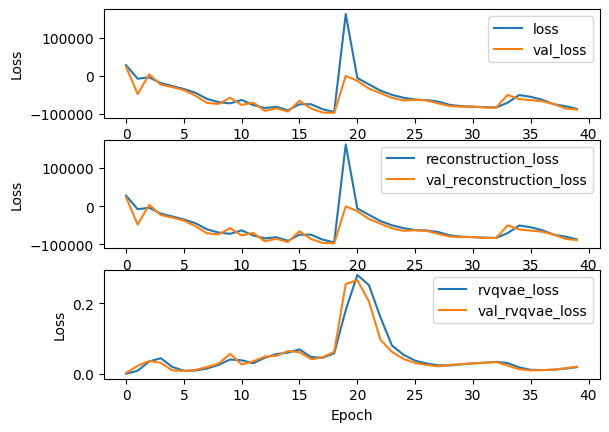

In [80]:
# Visualise the training and validation losses
fig, ax = plt.subplots(nrows=3,ncols=1)
metrics = ['loss','reconstruction_loss','rvqvae_loss']
for i in range(len(metrics)):
    ax[i].plot(model_3_hist.history[metrics[i]],label = metrics[i])
    ax[i].plot(model_3_hist.history["val_"+metrics[i]],label = "val_"+metrics[i])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss')
    ax[i].legend()
fig.show()

In [81]:
# Reconstruct some of the audio clips form the validation data
for elem in val_ds.take(1):
    val_batch = elem

In [96]:
# Test function
audio = spect_to_waveform(val_batch[4])
Audio(audio,rate=8000)

In [97]:
trained_model_3 = Sequential([
    rvqvae_trainer.encoder,
    rvqvae_trainer.rvq_layer,
    rvqvae_trainer.decoder
])

In [98]:
pred_spects = trained_model_3.predict(val_batch)

2/2 [==============================] - 0s 6ms/step


In [99]:
pred_audio = spect_to_waveform(pred_spects[4])
Audio(pred_audio,rate=8000)

This made the reconstruction a lot works. The probabilistic nature of the output is probably introducing some noise here

b) The VQ-VAE quantisation layer emits a sequence of discrete codes for a given audio input. During training, the prior distribution over these codes is kept uniform. In order to use the model to generate audio, it is necessary to train a second model to predict likely sequences of codebook vectors. 

This second model is usually referred to in the literature as a 'prior' model (note that this is not really a prior, as it is trained on the data). We will adopt this same terminology here.

You should design, implement and train a prior model to generate sequences of codebook vectors, using the output of the trained VQ-VAE encoder and quantisation stage, using the same training data that was used to train the VQ-VAE. You are again free to choose any architecture for the prior model.

Your trained model should generate a sequence that can be decoded by the VQ-VAE to output audio.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best set of hyperparameters, according to your validation results. You should aim to try at least two sets of hyperparameters.

Display some examples (playable using the Audio class from the IPython.display module as in question 1) generated using your prior and VQ-VAE model.

**(15 marks)**

### Question 4 (Total 15 marks)

Provide a separate PDF report with an account of the models and experiment design you have made in question 3. Your report should include details of the choices you have made throughout the development of the models, including the data processing, architecture design, hyperparameter settings/experiments and training algorithm. Where appropriate, you can also provide your intuition behind these choices. 

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time?

Marks will be awarded for presentation and clarity. Your report should be no more than 2-3 pages.

**(15 marks)**